# $\color{purple}{\text{FOMC Statements (2007-2022):}}$

## $\color{purple}{\text{Reading Between the Lines}}$

<img src = "../raw/FOMC_Meeting.jpg" width="1200" />

**Alexander Ng & Philip Tanofsky**    __Data 620 - Web Analytics__

**May 22, 2022**

## $\color{blue}{\text{Executive Summary}}$



The Federal Open Market Committee (FOMC) produces policy statements that are closely analyzed by financial markets, politicians and business leaders.
*   We analyze a corpus of 126 FOMC statements from Jan 2007-May 2022 using natural language processing methods and 

*   compare the statements to financial market variables, economic indicators and known policy initiatives of the Federal Reserve.


Using Latent Dirichlet Allocation (LDA), our findings are:
*  $N=5$ topics suffices to model the FOMC statements

*  topic weights vary like step functions with either 0% or 100% weights

*  a strong temporal link between topic inception and the four programs of quantitative easing (QE) 

*  other standard LDA plots are unhelpful in discovering the latent variable: QE regimes.

Using sentiment analysis, our findings are:

* A comparison of 4 methods to extract sentiment of the FOMC statements finds the Loughran-McDonald polarity measure to perform best, coinciding with the 2008, 2020 recession.

*  We regress sentiment changes to financial asset returns and macroeconomic variable changes over longer time horizons and find no statistical significant effect - a result consistent with market efficiency.

*  The sign of the regression coefficients of the change in macroeconomic indicators versus subsequent sentiment changes are consistent with our expectations.

## $\color{blue}{\text{1 - Introduction}}$

* 1 - Prior Research
* 2 - Exploratory Data Analysis and Wrangling
* 3 - LDA Model Topics correspond to QE Waves
* 4 - FOMC Sentiment Analysis
* 5 - Discussion

The Federal Open Market Committee (FOMC) is the key decision making body at the US Federal Reserve.  It sets the target Federal Funds interest rate, sets monetary policy to meet its dual mandate on managing inflation to a moderate and stable target of 2 percent and maximum employment consistent with the inflation target.  The FOMC statement is released every 6-8 weeks and announces the new target interest rate, views of current and future economic conditions and provides an outlook for future rates and asset purchases.  FOMC statements affect financial markets and business investment decisions.


A great deal of academic research has investigated the FOMC statements, minutes, transcripts.   Machine learning and time series studies have been applied to FOMC corpora as well.  Sentiment analysis and study of FOMC communications impact on markets and economics have been extensive.  The related work cited below is just a sample.
[Rosa (2013)](#Rossa2013) finds that FOMC statements move asset prices by increasing volatility of 10 year Treasury yields, SP500 Index returns, Euro-USD, Swiss Franc-USD, Japanese Yen-USD FX rates within 5 minutes of the statements release.    [Lucca and Trebbi (2009)](#LuccaTrebbi2009)    find that the hawkish or dovish tone of the FOMC statements can influence longer maturity Treasury rates.
[Gu, Kurov, Wolfe (2018)](#GuKurovWolf2018) find a 49 basis point increase in U.S. stock prices within the first hour after recent FOMC announcements.   [Cieslak, Morse, Vissing-Jorgensen (2019)](#CieslakMorseVissingJorgensen2019) shows much of the U.S. equity premium since 1994 has been earned on even numbered weeks tied to the FOMC meeting cycle.   They propose a causal explanation in terms of informal communications from the Fed.   Sentiment analysis using the positive and negative tone of the FOMC minutes using the financially oriented Loughran-McDonald dictionary has been demonstrated by [Cannon (2015)](#Cannon2015) to have significant correlation to real economic indicators.   Cannon showed a 26% positive correlation between the sentiment of Fed members to the Chicago Fed National Activity Index (CFNAI).


[Gutierrez, et. al. 2020](#Gutierrez2020) apply LDA analysis to FOMC statements to compare topics between the 2008 Financial Crisis and the 2020 Covid-19 pandemic.  They find similarities in concern in the topics associated with each crisis period.  Moreover, our technical approach using `Python`, `gensim` and `pyLDAvis` closely follows the approach of [Gutierrez, et. al. 2020](#Gutierrez2020).  However, we disagree on two key conclusions:  (a) that the Covid-19 pandemic was a more severe crisis than the 2008 Financial Crisis and (b) the absence of a clear topic interpretation.   
[Lagana, 2020](#Lagana2020) applies LDA analysis to both FOMC statements and FOMC minutes to identify variation in topics as a result of a change of policy in forward guidance by the Federal Reserve.   Her work finds no evidence of change in topic weight related to transparency in the statements.   [Jegadeesh and Wu (2015)](#JegadeeshWu2017) applied LDA to FOMC minutes and statements.  They find minutes are informative and they conduct a detailed event study between minutes releases and intraday asset returns.  They find a relationship between topic content and market volatility.  However, they argue that topic modeling is inappropriate for FOMC statements because of their brevity.   We disagree with the latter point as we find evidence that topics linked to Quantitative Easing programs.


* In [section 2](#section2), we prepare the dataset and explore the FOMC statement characteristics and the time series of relevant macroeconomic and financial variables.  

* Then, we produce a Latent Dirichlet Allocation topic model of the corpus showing the topic identification to Quantitative Easing programs in [Section 3](#section3).   

* In [Section 4](#section4), we extract the FOMC statement sentiment and consider long term regressions of sentiment against financial and economic variables.  

* [Section 5](#section5) summarizes our findings and Section 7 contains detailed tables of LDA topic weights, sentiment data.

## $\color{blue}{\text{2 - Preliminaries and Exploratory Data Analysis}}$  <a id='section2'></a> 

This section prepares the datasets and explores the some trends of the FOMC statements and their related macroeconomic and financial timeseries from the 2007-2022 period.

*  FOMC Corpus
*  FRED Time Series
*  Time Dynamics - Leads and Lags
*  Visualizating the Data






### $\color{green}{\text{2.1 - FOMC Corpus}}$

In this section, we describe the data preparation steps to obtain the FOMC statement corpus.

Each statement is individually retrieved from the Federal Reserve website (www.federalreserve.gov) based on the date of the Fed meeting. The list of URLs was manually reviewed and confirmed as accurate. Using an API request to the site and the `BeautifulSoup` library, the date of issuance and the statement text are scraped from the webpage. Given the formulaic nature of the statements, the final sentence is identified to ensure extraneous text is not included in the statement raw text. The length is determined by splitting each statement by whitespace, and the chairperson is determined by date.


The dataframe of the FOMC statements and metadata follows the following format.

- **statement_id:**   integer primary key 1..n
- **date:**                formatted date of the statement's issuance
- **year:**                year of the statement's issuance
- **text:**                 content of the statement 
- **length:**             number of words
- **chairperson:**    Last name of FOMC Chairman at time of statement issuance

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from datetime import datetime

We wrote a function to make an API request and scrape the page for the date and full statement based on a statement's individual URL.

In [3]:
# Approach from R-Bloggers
# https://www.r-bloggers.com/2014/11/fomc-dates-scraping-data-from-web-pages/
# Code for webscraping HTML
# https://stackoverflow.com/questions/1843422/get-webpage-contents-with-python

# Input: URL for a FOMC statement
# Output: list with the following values by index
#         0: Date
#         1: Year
#         2: URL
#         3: FOMC statement text
#         4: Word count
#         5: Chairperson
def build_fomc_row(url):
    # Request webpage and use BS for HTML parsing
    article_response = requests.get(url)
    soup = BeautifulSoup(article_response.content)
    
    # Find the statement section based on the id of 'article'
    lines = soup.find('div',{'id':'article'}).text.splitlines()
    
    msg_instance = []
    idx = 0

    # Loop through the resulting lines to only keep those with info
    # Some lines are whitespace only
    # Lines expected by index
    #     0: Date
    #     1: title
    #     2: For release
    #     3: 'Share'
    #     4 through n-2: Message itself
    #     n-2: Participants # Not always accurate
    #     n-1: 'Implementation Note' # Not always present
    for line in lines:
        ln = line.strip()
        if len(ln) > 0:
            idx = idx+1
            msg_instance.append(ln)
    
    # Find the index of the final sentence to locate end of message
    idx_final = 0
    for m in range(len(msg_instance)):
        if msg_instance[m].startswith('In a related set of actions'):
            idx_final = m
        if msg_instance[m].startswith('In a related action'):
            idx_final = m
        if msg_instance[m].startswith('Voting against'):
            idx_final = m
        if msg_instance[m].startswith('Voting for') or msg_instance[m].startswith('Voting in favor'):
            idx_final = m

    # Combine article into 1 text block based on the list structure after html parsing 
    # and the index of voting sentence
    article = ''
    for x in range(4, idx_final+1):
        if x > 4:
            article = article + ' ' + msg_instance[x]
        else:
            article += msg_instance[x]
            
    # Troubleshooting for statements that may not actually be true FOMC statement
    if 'Voting' not in article:
        print(url)
        return 'NOT FOMC'
    
    # Used to troubelshoot statements that didn't match final sentence patterns 
    debug = False
    if debug:
        if len(msg_instance)-1 > idx_final:
            print(url)
            print(msg_instance[idx_final+1])
    
    # Determine word count (naive approach based on whitespace split)
    length = len(article.split())
    
    # Build a list as the final output
    msg_instance_final = []
    msg_instance_final.append(msg_instance[0]) # Date
    msg_instance_final.append(msg_instance[0][-4:]) # Year
    msg_instance_final.append(url) # statement url
    msg_instance_final.append(article) # text
    msg_instance_final.append(length) # word count length
    # Convert date to formal python date format
    msg_instance_final[0] = datetime.strptime(msg_instance_final[0].replace(',',''), '%B %d %Y')
    
    # Based on date of fomc, determine and append chairperson name
    # Bernanke, Yellen, Powell
    if msg_instance_final[0] <= datetime(2014, 1, 31):
        msg_instance_final.append('Bernanke')
    elif msg_instance_final[0] <= datetime(2018, 2, 3):
        msg_instance_final.append('Yellen')
    else:
        msg_instance_final.append('Powell')

    # Return list for one fomc statement
    return msg_instance_final

In [4]:
# TEST CASE
# Un-comment to run
#build_fomc_row('https://www.federalreserve.gov/newsevents/pressreleases/monetary20220126a.htm')

We compiled a complete list of FOMC statements based on manual research from 2007 to the time of this report (May 2022).
We included only statements issued after FOMC meetings where the target Federal Funds rate was considered.
This excluded extraordinary statements that did not consider target Federal Funds rate changes.

In [5]:
final_list= [
    '/newsevents/press/monetary/20070131a.htm',
    '/newsevents/press/monetary/20070321a.htm',
    '/newsevents/press/monetary/20070509a.htm',
    '/newsevents/press/monetary/20070618a.htm',
    '/newsevents/press/monetary/20070807a.htm',
    '/newsevents/press/monetary/20070918a.htm',
    '/newsevents/press/monetary/20071031a.htm',
    '/newsevents/press/monetary/20071211a.htm',
    '/newsevents/pressreleases/monetary20080122b.htm',
    '/newsevents/press/monetary/20080130a.htm',
    '/newsevents/press/monetary/20080318a.htm',
    '/newsevents/press/monetary/20080430a.htm',
    '/newsevents/press/monetary/20080625a.htm',
    '/newsevents/press/monetary/20080805a.htm',
    '/newsevents/press/monetary/20080916a.htm',
    '/newsevents/press/monetary/20081008a.htm',
    '/newsevents/press/monetary/20081029a.htm',
    '/newsevents/pressreleases/monetary20081216b.htm',
    '/newsevents/press/monetary/20090128a.htm',
    '/newsevents/press/monetary/20090318a.htm',
    '/newsevents/press/monetary/20090429a.htm',
    '/newsevents/press/monetary/20090624a.htm',
    '/newsevents/press/monetary/20090812a.htm',
    '/newsevents/press/monetary/20090923a.htm',
    '/newsevents/press/monetary/20091104a.htm',
    '/newsevents/press/monetary/20091216a.htm',
    '/newsevents/press/monetary/20100127a.htm',
    '/newsevents/press/monetary/20100316a.htm',
    '/newsevents/press/monetary/20100428a.htm',
    '/newsevents/press/monetary/20100623a.htm',
    '/newsevents/press/monetary/20100810a.htm',
    '/newsevents/press/monetary/20100921a.htm',
    '/newsevents/press/monetary/20101103a.htm',
    '/newsevents/press/monetary/20101214a.htm',
    '/newsevents/pressreleases/monetary20110126a.htm',
    '/newsevents/pressreleases/monetary20110315a.htm',
    '/newsevents/pressreleases/monetary20110427a.htm',
    '/newsevents/pressreleases/monetary20110622a.htm',
    '/newsevents/pressreleases/monetary20110809a.htm',
    '/newsevents/pressreleases/monetary20110921a.htm',
    '/newsevents/pressreleases/monetary20111102a.htm',
    '/newsevents/pressreleases/monetary20111213a.htm',
    '/newsevents/pressreleases/monetary20120125a.htm',
    '/newsevents/pressreleases/monetary20120313a.htm',
    '/newsevents/pressreleases/monetary20120425a.htm',
    '/newsevents/pressreleases/monetary20120620a.htm',
    '/newsevents/pressreleases/monetary20120801a.htm',
    '/newsevents/pressreleases/monetary20120913a.htm',
    '/newsevents/pressreleases/monetary20121024a.htm',
    '/newsevents/pressreleases/monetary20121212a.htm',
    '/newsevents/pressreleases/monetary20130130a.htm',
    '/newsevents/pressreleases/monetary20130320a.htm',
    '/newsevents/pressreleases/monetary20130501a.htm',
    '/newsevents/pressreleases/monetary20130619a.htm',
    '/newsevents/pressreleases/monetary20130731a.htm',
    '/newsevents/pressreleases/monetary20130918a.htm',
    '/newsevents/pressreleases/monetary20131030a.htm',
    '/newsevents/pressreleases/monetary20131218a.htm',
    '/newsevents/pressreleases/monetary20140129a.htm',
    '/newsevents/pressreleases/monetary20140319a.htm',
    '/newsevents/pressreleases/monetary20140430a.htm',
    '/newsevents/pressreleases/monetary20140618a.htm',
    '/newsevents/pressreleases/monetary20140730a.htm',
    '/newsevents/pressreleases/monetary20140917a.htm',
    '/newsevents/pressreleases/monetary20141029a.htm',
    '/newsevents/pressreleases/monetary20141217a.htm',
    '/newsevents/pressreleases/monetary20150128a.htm',
    '/newsevents/pressreleases/monetary20150318a.htm',
    '/newsevents/pressreleases/monetary20150429a.htm',
    '/newsevents/pressreleases/monetary20150617a.htm',
    '/newsevents/pressreleases/monetary20150729a.htm',
    '/newsevents/pressreleases/monetary20150917a.htm',
    '/newsevents/pressreleases/monetary20151028a.htm',
    '/newsevents/pressreleases/monetary20151216a.htm',
    '/newsevents/pressreleases/monetary20160127a.htm',
    '/newsevents/pressreleases/monetary20160316a.htm',
    '/newsevents/pressreleases/monetary20160427a.htm',
    '/newsevents/pressreleases/monetary20160615a.htm',
    '/newsevents/pressreleases/monetary20160727a.htm',
    '/newsevents/pressreleases/monetary20160921a.htm',
    '/newsevents/pressreleases/monetary20161102a.htm',
    '/newsevents/pressreleases/monetary20161214a.htm',
    '/newsevents/pressreleases/monetary20170201a.htm',
    '/newsevents/pressreleases/monetary20170315a.htm',
    '/newsevents/pressreleases/monetary20170503a.htm',
    '/newsevents/pressreleases/monetary20170614a.htm',
    '/newsevents/pressreleases/monetary20170726a.htm',
    '/newsevents/pressreleases/monetary20170920a.htm',
    '/newsevents/pressreleases/monetary20171101a.htm',
    '/newsevents/pressreleases/monetary20171213a.htm',
    '/newsevents/pressreleases/monetary20180131a.htm',
    '/newsevents/pressreleases/monetary20180321a.htm',
    '/newsevents/pressreleases/monetary20180502a.htm',
    '/newsevents/pressreleases/monetary20180613a.htm',
    '/newsevents/pressreleases/monetary20180801a.htm',
    '/newsevents/pressreleases/monetary20180926a.htm',
    '/newsevents/pressreleases/monetary20181108a.htm',
    '/newsevents/pressreleases/monetary20181219a.htm',
    '/newsevents/pressreleases/monetary20190130a.htm',
    '/newsevents/pressreleases/monetary20190320a.htm',
    '/newsevents/pressreleases/monetary20190501a.htm',
    '/newsevents/pressreleases/monetary20190619a.htm',
    '/newsevents/pressreleases/monetary20190731a.htm',
    '/newsevents/pressreleases/monetary20190918a.htm',
    '/newsevents/pressreleases/monetary20191030a.htm',
    '/newsevents/pressreleases/monetary20191211a.htm',
    '/newsevents/pressreleases/monetary20200129a.htm',
    '/newsevents/pressreleases/monetary20200303a.htm',
    '/newsevents/pressreleases/monetary20200315a.htm',
    '/newsevents/pressreleases/monetary20200429a.htm',
    '/newsevents/pressreleases/monetary20200610a.htm',
    '/newsevents/pressreleases/monetary20200729a.htm',
    '/newsevents/pressreleases/monetary20200916a.htm',
    '/newsevents/pressreleases/monetary20201105a.htm',
    '/newsevents/pressreleases/monetary20201216a.htm',
    '/newsevents/pressreleases/monetary20210127a.htm',
    '/newsevents/pressreleases/monetary20210317a.htm',
    '/newsevents/pressreleases/monetary20210428a.htm',
    '/newsevents/pressreleases/monetary20210616a.htm',
    '/newsevents/pressreleases/monetary20210728a.htm',
    '/newsevents/pressreleases/monetary20210922a.htm',
    '/newsevents/pressreleases/monetary20211103a.htm',
    '/newsevents/pressreleases/monetary20211215a.htm',
    '/newsevents/pressreleases/monetary20220126a.htm',
    '/newsevents/pressreleases/monetary20220316a.htm',
    '/newsevents/pressreleases/monetary20220504a.htm' # Including final statement from May 2022
]

Now that we have all the fomc statement links, we will construct a list for each statement that will eventually be 1 row in a `Pandas` dataframe of all the statements.

In [6]:
# Domain for all the FOMC statement URLs
domain = 'https://www.federalreserve.gov'

# Set to True, if fresh retrieval of statements is needed
retrieve_statements = False
if retrieve_statements:
    # List to contain the FOMC with metadata
    # This will be a list of lists, as each item is a list of an fomc statement and its metadata
    fomc_list_of_rows = []

    # Loop through all the fomc links to create the list of lists (ie, creating the dataframe form)
    for article in final_list:
        art_url = domain + article
        fomc_row = build_fomc_row(art_url)
        if fomc_row != 'NOT FOMC':
            fomc_list_of_rows.append(fomc_row)
        else:
            if False:
                print('ERROR with FOMC url: ' + art_url)

    # Define the columns wanted and create the Pandas DF
    columns = ['date', 'year', 'url', 'text', 'length', 'chairperson']
    fomc_articles_df = pd.DataFrame(fomc_list_of_rows,columns=columns)
    # Sort by date
    fomc_articles_df = fomc_articles_df.sort_values(by='date', ascending=True)
    # Add statement_id unique identifier
    fomc_articles_df['statement_id'] = range(1, len(fomc_articles_df) + 1)
    # Reset the column order
    fomc_articles_df = fomc_articles_df[['statement_id', 'date', 'year', 'url', 'text', 'length', 'chairperson']]
    # Output the DF for visual inspection
    fomc_articles_df

Finally, we write the dataframe of FOMC statements to CSV.

In [7]:
# Note: Set to True, if the retrieval is necessary, otherwise, data collection is complete, just use generated CSV
if retrieve_statements:
    fomc_articles_df.to_csv('FOMC_statements.csv', index=False)

### $\color{green}{\text{2.2 - FRED Time Series}}$

#### Data Source

The source of the time series data is the Federal Reserve Economic Data site [(FRED economic database)](https://fred.stlouisfed.org/) operated by the Federal Reserve Bank of St. Louis.   We consider 4 financial time series from the FRED database which represent interest rates, credit, inflation and equity markets.

*  **BAA10Y**, Moody's Seasoned Baa Corporate Bond yield relative to yield on 10-year Treasury Constant Maturities.  

*  **T10YIE**, the breakeven inflation rate represents the expected inflation derived from 10-Year Treasury constant maturity securities minus the 10-Year Treasury Inflation-Indexed Constant Maturity index.  It represents market expectations of average inflation over the next 10 years.

*  **WILL5000IND**, the total returns of the Wilshire 5000 Stock Index, observed daily, including reinvested dividends.  This is a broad measure of the entire US stock market.

*  **DGS10**, the yield on 10-year Treasury Constant Maturities.

Each of the above financial time series is observed at daily interval and reflected the values at market close 4pm EST.


We also consider 3 macroeconomic variables which are published at monthly frequency for the US economy.  These are also sourced from the FRED database.

*  **UNRATE**, the U-3 measure of labor unemployment as published monthly by the Bureau of Labor Statistics (BLS), expressed as a percentage of the labor force of people 16 years of age or older, who are not in institutions or active military duty.  This statistic is reported for the prior month.

*  **CIVPART**, the Labor Force Participation Rate, measures the percentage of people in the labor force as a percentage of population of civilian noninstitutionalized people.

*  **PCEPILFE**, the Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index), indexed to 2012=100, is the preferred measure by the FOMC of price increases in the US.   It is a measure of the price paid for goods and services in the US.  It measures actual inflation on a backward looking basis.


We do NOT include real GDP as an regression variable for several important reasons:

*  GDP is published quarterly, but FOMC sentiment is published every 6-8 weeks.  Thus, sentiment will change regardless of the prior GDP quarterly figure.   The mismatch in periodicity cannot easily be resolved.

*  GDP is updated 3 times as an initial release, secondary and third release.   Each release includes more complete information to estimate Gross Domestic Product.  While each revision is known to influence markets, the value of each revision is serially correlated to earlier releases.  

*  GDP release schedules don't follow a simple chronological pattern.


This section loads, imputes missing values and constructs the time series of returns or indices for regression and comparison with the sentiment indicator.

The section also demonstrates the regression between sentiment and financial or macroeconomic variables.


#### Cleaning the Data

We process each FRED time series but forward filling each missing value.  Missing values occur on market holidays.
Thus, forward filling avoids backtest look-ahead bias.  We also need to coerce the data series from string to numeric which is done using `pandas.to_numeric()` call.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#from pandas import read_csv

fred_dir = "../fred/"

def process_fred_dateseries( csv_file, series_name ):

#  header = 0  the header row is located at row index 0
#  parse_dates - dates are at column index 0
#  index_col  -  first column is the index for the Time Series object
#
# ----------------------------------------------------
    
    df = pd.read_csv(csv_file, header = 0, parse_dates = [0], index_col = 0 )
    
    # convert blank or missing data to nan and other values from string to numeric
    df[series_name] = pd.to_numeric( df[series_name], errors = 'coerce')
    
    # Fill forward any missing data on a business holiday.
    #
    df.fillna( method = "ffill", inplace = True )
    
    df.reset_index(inplace=True)
    
    return df

#
#   Series filenames are <SERIES-KEY>.csv
#
#   Series file content:  <date>, <series-key>
# ----------------------------------------------------------------------------
def load_and_display_fred_dateseries( series_list , show_plot = False):
    
    dict_series = { }
    
    for series in series_list:
    
        sfilename = fred_dir + series + ".csv"
        
        df_series = process_fred_dateseries( sfilename, series)
        
        dict_series.update({ series : df_series } )
        
        if show_plot:
            df_series.plot( y = series )
            plt.show()
        
    return dict_series


When we run the above function on our list of FRED time series, the function returns the cleansed, imputed data series in a single object - a dictionary.

That dictionary contains a sequence of key-value pairs:

*  `key`:  the series name 

*  `value`:  pandas DataFrame whose column is the imputed data value as the series.

In addition, when we set the parameter `show_plot` = `True`, we obtain a time series plot of each series as a side-effect.


In [9]:
#
#  All the data series to be used in regression analysis.  
# -------------------------------------------------------------------------------------------
series_list = ["BAA10Y", "T10YIE", "WILL5000IND", "DGS10", "UNRATE","CIVPART",   "PCEPILFE"]

#
# Store the data series in a dictionary with:
#    key:   series key
#    value: DataFrame of dates, raw time series valuees
# 
dict_series = load_and_display_fred_dateseries(series_list, show_plot = False)


## Time Dynamics

The FOMC meetings occur at 2pm EST.   We generate a series of returns for each financial variable and changes for each economic variable.

We will check if FOMC sentiment appears to influence future changes in financial markets.
For the financial variables, we consider percentage changes at 2-day and 5-day intervals.   These changes will be regressed against changes in FOMC sentiment to detect relationships.   


We will check if FOMC sentiments appears to be influenced by past changes in economic variables. We will measure monthly changes in personal consumption, unemployment and labor participation rates and see if past changes appear to influence future changes in FOMC sentiment.

Additional data columns are appended to the dataframe of each series within the series dictionary object.

We also visualize each resultant time series of returns along with the original time series.


In [10]:


def transform_fred_dateseries( series_dict, series_key, period, is_pct , col_name , forward_shift = 1):
    
    df_series = series_dict[ series_key]
    
    if is_pct:
        df_series[ col_name ] = df_series[series_key].pct_change( periods = period )
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift
    else:
        df_series[ col_name ] = df_series[series_key].diff( periods = period )
        
        if period < 0:
            df_series[ col_name ] = -1 * df_series[ col_name]
        df_series[ col_name ] = df_series[col_name ].shift( periods = forward_shift)  # Forward shift

transform_fred_dateseries( dict_series, "BAA10Y", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "BAA10Y", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "T10YIE", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "T10YIE", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "WILL5000IND", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "WILL5000IND", -5,  is_pct = True, col_name = "fp5")

transform_fred_dateseries( dict_series, "DGS10", -2,  is_pct = True, col_name = "fp2")
transform_fred_dateseries( dict_series, "DGS10", -5,  is_pct = True, col_name = "fp5")

#
# Look back 1 month for Labor Participation Rate.  Use absolute rate change.
# 
# Join the monthly FOMC meeting to the same-month-CIVPART value and compare:
# sentiment Y of the FOMC and its prior-period change dY vs.  bd1 of the same-month-CIVPART 
#  
# Check if bd1 predicts dY
transform_fred_dateseries( dict_series, "CIVPART", 1,  is_pct = False, col_name = "bd1")

# Join the monthly FOMC meeting to the same-month-UNRATE value and compare:
# sentiment Y of the FOMC and its prior-period change dY vs.  bd1 of the same-month-UNRATE
#  
# Check if bd1 predicts dY
transform_fred_dateseries( dict_series, "UNRATE", 1,  is_pct = False, col_name = "bd1")

#
#  PCEPILFE is released monthly on a backward looking basis near the end of the following month.
#  E.g.
#        PCE[ Jan 2022] is published late Feb 2022 and would be available for an March 2022 FOMC meeting.
#
#  So we would shift the 12 month change in Jan 2022 PCEILFE to March 2022 bp12 data point.
#  i.e. use a 2 month forward shift
#
#  Regress if bp12 predicts change in sentiment dY
transform_fred_dateseries( dict_series, "PCEPILFE", 1,  is_pct = True, col_name = "bp12", forward_shift = 2)




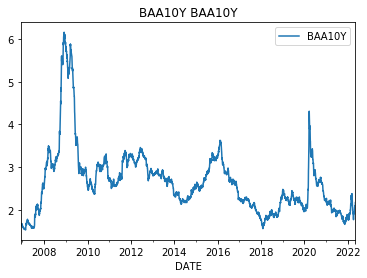

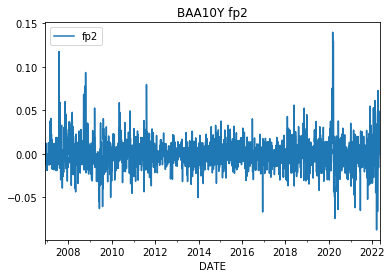

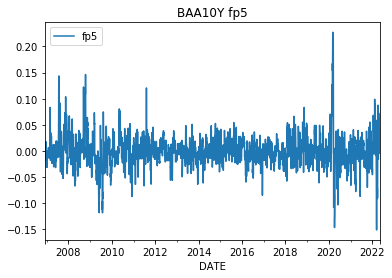

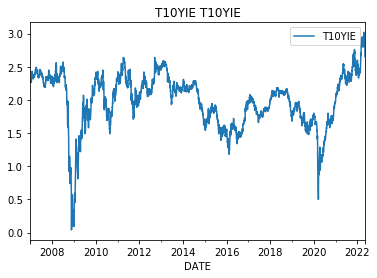

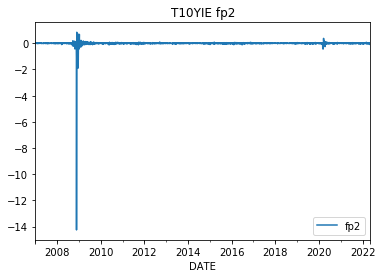

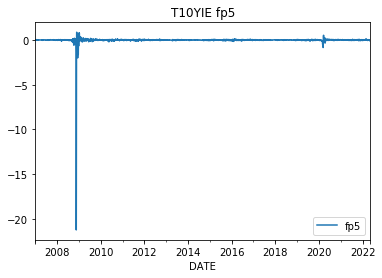

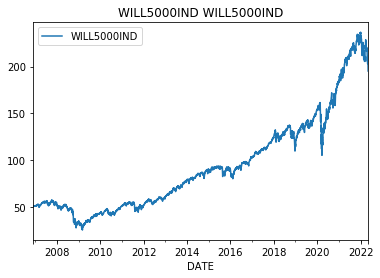

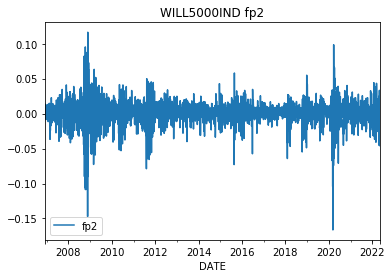

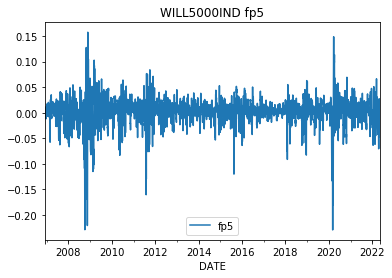

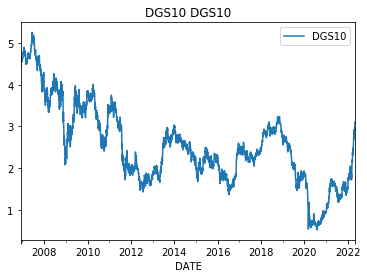

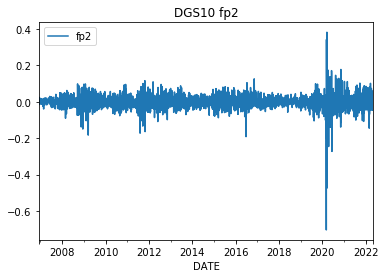

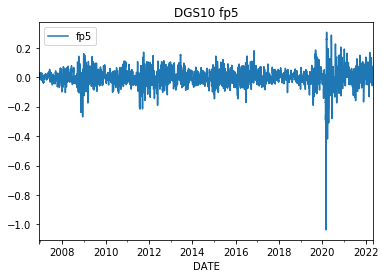

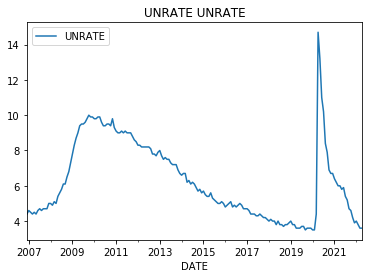

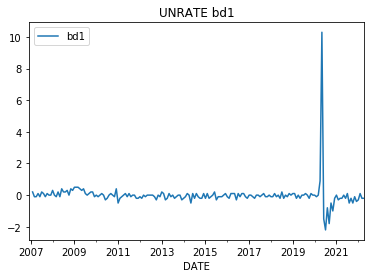

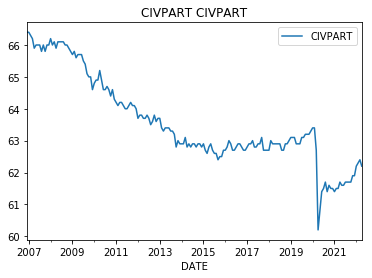

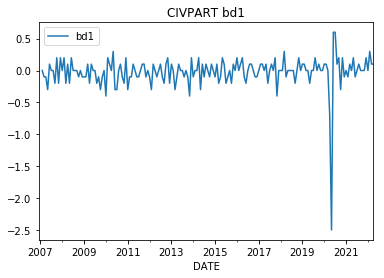

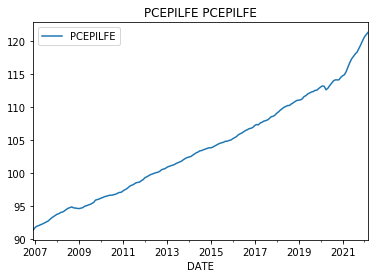

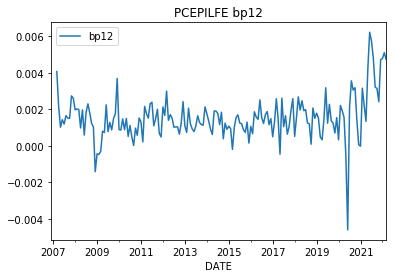

In [11]:
#
# Display plots of all the time series and their transforms.
# 
# Outer loop is the series key
for v in dict_series:
    
    # inner loop is all data columns
    # only works if date is an index - not a column
    for u in dict_series[v]:
        
        if u != "DATE":
            dict_series[v].plot( x = "DATE", y = u)
            plt.title(v + " " + u)
            plt.show()


### $\color{green}{\text{2.3 - Exploratory Data Analysis}}$

We consider some aspects over this lengthy period:

*   the linguistic patterns of FOMC statements in different regimes
*   the federal funds target rate over this period.  This rate is set within each FOMC statement and is viewed as an `output` of the FOMC process.
*   the macroeconomic variables including economic growth, inflation and labor market conditions.  These indicators are key `inputs` to the FOMC process.
*   financial market variables are both `inputs` and responses to the FOMC process.

### Linguistic Patterns

As the chairperson and the members of the FOMC committee write and/or approve the text language, we expect textual variations due to the chairperson.
The below table and chart shows the FOMC policy statement length (in words) by chairperson and time.

*  Ben Bernanke was the Federal Reserve chairman from 2006 - 2014.  (https://www.federalreservehistory.org/people/ben-s-bernanke)
*  Janet Yellen was the Federal Reserve chairwoman from 2014 - 2018.  (https://www.federalreservehistory.org/people/janet-l-yellen)
*  Jerome Powell is the current Federal Reserve chairman from 2018 - present.  (https://www.federalreservehistory.org/people/jerome-h-powell)


Stylistically, we see that the length of statements during Bernanke's chairmanship increased in length from 2007-2014 due to a desire to provide greater transparency to financial markets and decision makers. Overall, his statements averaged 442 words each but increased from 200 to nearly 900 at their peak.

Janet Yellen's statements grew in length and reading complexity. Her statements averaged 602 word but declined over time. According to Hernandez & Shell, the reading complexity of Yellen's statements reached grade level 18 and 19 using the Flesch-Kincaid index. This implied Yellen's statements required 3-4 years of post-graduate education to be understood.

Powell's statements declined in length and reading complexity with an average statement length of 407 words during his tenure.


In [12]:
%matplotlib inline

In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable()

In [14]:
import io
import os.path
import math
#import requests
#from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
import smart_open

# Prepare corpus
derived_data_dir = "../derived"

fomc_statements_file = derived_data_dir + "/" + "FOMC_statements.csv"

df_fomc_statements_raw = pd.read_csv( fomc_statements_file )

docs = df_fomc_statements_raw.text

In [15]:
%matplotlib inline
def plot_fomc_statement_length():
    freq = 5
    fig, ax = plt.subplots()
    sns.set( rc = { 'figure.figsize' : ( 20, 12 ) } )
    sns.set( font_scale = 2 )
    p = sns.lineplot( x = 'date', y = 'length', hue = 'chairperson' , 
             style  = 'chairperson' ,
             marker = 'o', data = df_fomc_statements_raw, ax = ax )

    p.set_xlabel( "Date", fontsize = 14 )
    p.set_ylabel( "Text Length", fontsize = 14 )

    ax.set_xticklabels( df_fomc_statements_raw.iloc[::freq].date )
    xtix = ax.get_xticks()
    ax.set_xticks( xtix[::freq ] )
    fig.autofmt_xdate()

    plt.title("FOMC Statement Length by Chairperson" )
    plt.savefig("../raw/FOMC_Statement_Length_By_Chair.png")
    plt.show()


In [16]:
generate_plots = False
if generate_plots:
    plot_fomc_statement_length()    

<img src = "../raw/FOMC_Statement_Length_By_Chair.png" width="1200" />

In [17]:
#
# Display average FOMC statement length by Chairperson
heading_properties = [('font-size', '18px')]
cell_properties = [('font-size', '16px')]
dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]
a = df_fomc_statements_raw.groupby('chairperson')[["length", "year"]].mean()


In [18]:
a.sort_values(by=["year"] )[["length"]].style.set_table_styles(dfstyle)

,length
chairperson,
Bernanke,442.949153
Yellen,602.656250
Powell,407.942857


###  Federal Funds Target Rates

During the study period, we see that the FOMC target for the federal funds rate varied significantly.
Moreover, during the 2008 financial crisis, the FOMC changed its practice from setting a single rate to setting a target range with a lower and upper bound on the range.
The key features of the rate setting over this period are:

*  Rate reduced from 5-1/4 percent in 2007 to 0-1/4 percent target rate in 2009 as the 2008 Financial Crisis worsened.
*  Lengthy period of near zero target rate from 2009 - 2016 as the FOMC tried to resuscitate a weak labor market and weak inflation.
*  Steady rate increases from 2016-2020 as economic conditions and labor markets improved.
*  Rate cuts from 2020-Jan 2022 to battle the economic effects of the Covid-19 pandemic.
*  Rate increases from March 2022 to battle inflation.


<img src="../fred/FEDFUNDS_HISTORY.png" width="1200" />

###  Macroeconomic Conditions

We examine the unemployment rate (U-3) `UNRATE` and the Labor Participation Rate `CIVRATE`, defined as the percentage of
of people in the labor force as a percentage of the civilian noninstitutional population.
Both statistics are reported monthly by the Bureau of Labor Statistics.  The chart below shows their time series.

*  `CIVRATE` shows a steady decline from 66-62% from 2007-2015 before regaining some ground in 2016-2020.  The arrival of Covid-19 caused a massive decline in labor force participation to 60% in 2020.  This phenomenon has been called the `Great Resignation`.

*  `UNRATE` shows the traditional measure of unemployment.  It increased significantly during the 2008 financial crisis and remained high even after financial markets recoved in 2010.   However, the short term spike in unemployment during the Covid-19 pandemic showed that enormous economic cost of lockdowns and disruptions to businesses.



<img src="../fred/UNRATE_CIVPART_HISTORY.png" width="1200" />

Concurrently, we see that real GDP growth below.  Expressed in percentage form as the quarterly change in real GDP over a 12-month period, `GDPC1` shows a significant drop during both the 2008 Financial Crisis and the 2020 Covid-19 induced recession.   The rebound in GDP is sharper for the 2020 recession because its cause is physical rather than financial.

<img src="../fred/GDPC1_HISTORY.png" width="1200" />

### Financial Market Variables



We plot the previously mentioned 4 financial time series from the FRED database which represent interest rates, credit, inflation and equity markets.

*  **BAA10Y**, Moody's Seasoned Baa Corporate Bond yield relative to yield on 10-year Treasury Constant Maturities.  

*  **T10YIE**, the breakeven inflation rate represents the expected inflation derived from 10-Year Treasury constant maturity securities minus the 10-Year Treasury Inflation-Indexed Constant Maturity index.  It represents market expectations of average inflation over the next 10 years.

*  **WILL5000IND**, the total returns of the Wilshire 5000 Stock Index, observed daily, including reinvested dividends.  This is a broad measure of the entire US stock market.

*  **DGS10**, the yield on 10-year Treasury Constant Maturities.


We remark on observations grouped by period on each time series.

*  During the **2007-2009 Financial Crisis**:
    +   `BAA10Y`, the `Baa` Corporate Yield Spread, spiked before falling back to normal levels.
    +   `DGS10`, US Treasury 10-year yields, declined as investors bid up Treasuries in a flight-to-quality.
    +   `T10YIE`, US Treasury 10-year TIPS breakeven inflation, dipped to nearly zero, as investors worried about a long term financial meltdown.
    +   `WILL5000IND` fell sharply in late 2008 to early 2009 before rallying by end of 2009.

*  During the **2020 Covid-pandemic**:
    +   `BAA10Y` credit spreads spiked again but less sharply because the pandemic was viewed as a real-world crisis not a dysfunction in the financial markets.
    +   `DGS10`, US Treasury 10-year yields, hit record lows as investors, once again, bought Treasuries on a flight-to-quality.  This time, the lower rate environment meant actual yields were lower than in the 2007-2009 Financial Crisis.
    +   `T10YIE`, hit new lows before surging, as concerns about economic recession were placed by supply chain disruptions and labor shortages.

In [19]:
def plot_panel_financials():
    sns.set( rc = { 'figure.figsize' : ( 20, 12 ) } )
    img_list = ["BAA10Y", "DGS10", "T10YIE", "WILL5000IND" ]
    fig, axarr = plt.subplots(2,2)
    i = 0

    for series in img_list:
        r, c = divmod(i, 2)
        filename = "../fred/" + series + ".png"
        a = plt.imread(filename)
        axarr[r, c ].imshow( a )
        axarr[r, c ].set_axis_off()
        i += 1

    plt.show()


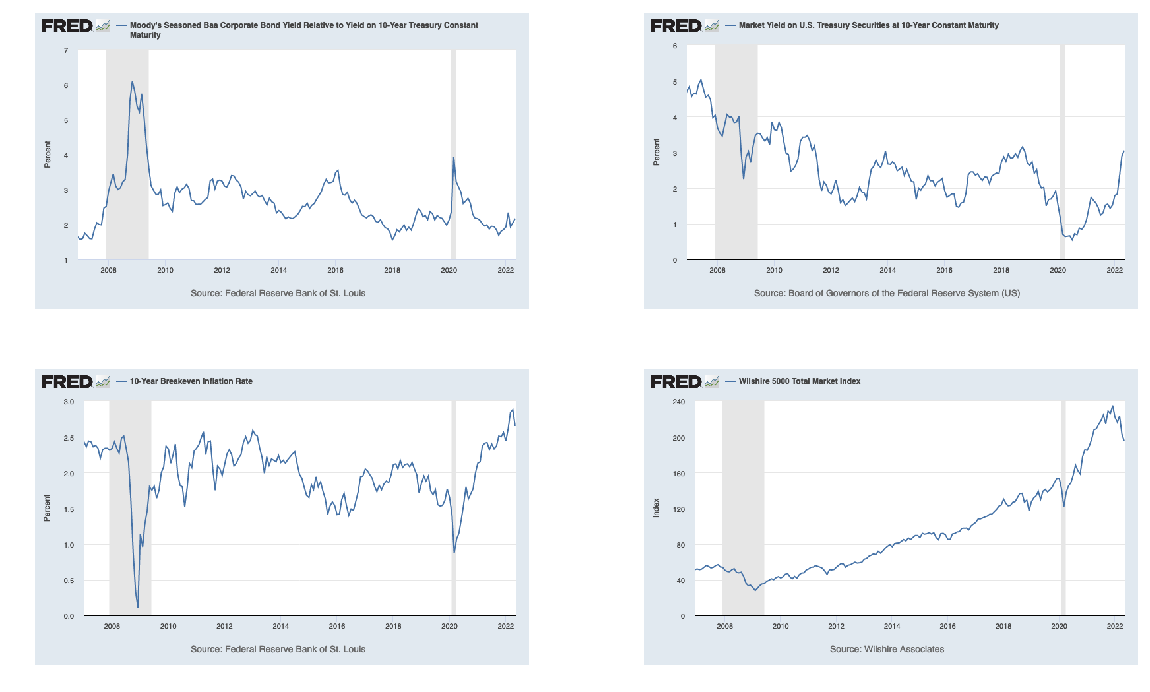

In [20]:
plot_panel_financials()

## $\color{blue}{\text{3 - Topic Modeling of FOMC Statements}}$ <a id="section3"></a>

* Preprocessing and Vectorization of Corpus
    +  Stopwords - FOMC specifics
    +  Bigrams, WordNet Lemmatizer
   
* N = 5 Topics Suffice using LDA.  
    +  Each Topic is associated with 1 period of QE
    
* Interpretation
    +  High Frequency Words in each Topic
    +  Word Clouds
    +  Time Variation of Topic Weights

The FOMC text is enormously influential to financial markets, businesses and governments.   We ask how textual analysis
can shed light on the FOMC statements through the recent critical period of the twenty-first century.

Using Latent Dirichlet Allocation, we construct a topic model of the FOMC statements from 2007-2022.  
Between January 2007-May 2022, we found 126 relevant FOMC policy statements. 

Our chief findings are that $N=5$ topics are sufficient to allow economic interpretation.
While the LDA model seems to detect topics based on the Federal Reserve quantitative easing policy more than the target interest rate.
Moreover, the high frequency words don't necessary reveal the topic.
Instead, we discovered that the link to Quantitative easing when we examine the dates when topic weights fluctuate in each FOMC statement.

This section begins by preprocessing the FOMC statement corpus.  Next, we train the LDA model and report the topics textually 
and graphically.   Next, we report the Time Variation of the Topics and their interpretation.   Lastly, we consider coherence as a topic evaluation measure for FOMC statements.   In our discussion, we consider potentially useful business application of LDA topic modeling as an automated form of Fed-watching.



### $\color{green}{\text{ 3.1 - Pre-process and vectorize the documents}}$

The statements were downloaded and extracted in a previous step for consumption.  There are 126 statements for use.  We use `gensim`, `nltk` to preprocess the corpus.


In [21]:
%matplotlib inline

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable()

In [23]:
import io
import os.path
import math
#import requests
#from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import gensim
import gensim.corpora as corpora
from gensim import models
import matplotlib.pyplot as plt
#import spacy
from pprint import pprint
from wordcloud import WordCloud
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import seaborn as sns
import re as re
import smart_open

# Prepare corpus
derived_data_dir = "../derived"

fomc_statements_file = derived_data_dir + "/" + "FOMC_statements.csv"

df_fomc_statements_raw = pd.read_csv( fomc_statements_file )

docs = df_fomc_statements_raw.text

In [24]:
df_fomc_statements_raw.tail()

,statement_id,date,year,url,text,length,chairperson
121,122,2021-11-03,2021,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve is committed to using its ...,614,Powell
122,123,2021-12-15,2021,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve is committed to using its ...,521,Powell
123,124,2022-01-26,2022,https://www.federalreserve.gov/newsevents/pres...,Indicators of economic activity and employment...,430,Powell
124,125,2022-03-16,2022,https://www.federalreserve.gov/newsevents/pres...,Indicators of economic activity and employment...,348,Powell
125,126,2022-05-04,2022,https://www.federalreserve.gov/newsevents/pres...,Although overall economic activity edged down ...,366,Powell


In [25]:
ldocs = list(docs)


Following the approach suggested by [Radim Rehurek](https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html#sphx-glr-auto-examples-tutorials-run-lda-py) in his LDA tutorial, our steps include:

* Tokenize (split the documents into tokens).
* Lemmatize the tokens.
* Compute bigrams.
* Compute a bag-of-words representation of the data.
* Convert the bag-of-words to Term Document - Inverse Document Frequency Weighting.


First we tokenize the text using a regular expression tokenizer from NLTK. We remove numeric tokens and tokens that are only a single character, as they don't tend to be useful, and the dataset contains a lot of them.

We also add FOMC specific stopwords as they don't appear to add value to the statements. These include the words chair, vice, voting, committee and FOMC. They also include the first and last names of all FOMC members from 2007-2022. These were identified manually on the Federal Reserve website.

In [26]:
# Tokenize the documents.
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# common stop words in the English language
en_stopwords = stopwords.words('english')

# FOMC stop words
FOMC_stopwords = ['chair', 'vice', 'voting', 'committee', 'FOMC' ,
                 'john', 'williams', 'bowman', 'michelle', 'lael', 'brainard',
                  'james', 'bullard', 'esther', 'george', 'loretta', 'mester',
                  'christopher', 'waller'
                  'ben', 'bernanke', 'richard', 'clarida', 'stanley', 'fischer',
                  'susan', 'bies', 'elizabeth', 'duke', 'donald', 'kohn', 
                  'randall', 'kroszner', 'frederic', 'mishkin' ,
                  'jerome', 'powell', 'randal', 'quarles', 
                  'sarah', 'raskin', 'jeremy', 'stein' , 'daniel', 'tarullo',
                  'kevin', 'warsh', 'janet', 'yellen', 'tom', 'barkin',
                  'raphael', 'bostic' , 'mary', 'daly', 'william', 'dudley' ,
                  'charles', 'evans', 'fisher', 'timothy', 'geithner', 
                  'patrick', 'harker' , 'eric', 'rosengren', 'gary', 'stern',
                  'thomas', 'hoenig', 'robert', 'kaplan', 'neel', 'kashkari' ,
                  'narayana', 'kocherlakota', 'jeffrey', 'lacker', 
                  'dennis', 'lockhart' , 'cathy', 'minehan', 'michael', 'moskow',
                  'susan', 'pianalto', 'charles', 'plosser', 'william', 'poole'
                 ]

all_stopwords = set( en_stopwords + FOMC_stopwords )

# Split the documents into tokens.
tokenizer = RegexpTokenizer(r'\w+')

for idx in range(len(ldocs)):
    ldocs[idx] = ldocs[idx].lower()  # Convert to lowercase.
    ldocs[idx] = tokenizer.tokenize(ldocs[idx])  # Split into words.

# Remove numbers, but not words that contain numbers.
ldocs = [[token for token in doc if not token.isnumeric()] for doc in ldocs]

# Remove words that are only one character.
ldocs = [[token for token in doc if len(token) > 1] for doc in ldocs]

We use the WordNet lemmatizer from NLTK. A lemmatizer is preferred over a
stemmer in this case because it produces more readable words. Output that is
easy to read is very desirable in topic modelling.




In [27]:
# Lemmatize the documents.
lemmatizer = WordNetLemmatizer()
lemma_docs = [[lemmatizer.lemmatize(token) for token in doc if token not in all_stopwords ] for doc in ldocs]

We find bigrams in the documents. Bigrams are sets of two adjacent words.
Using bigrams we can get phrases like "public_health" in our output
(spaces are replaced with underscores); without bigrams we would only get
"public" and "health".

Note that in the code below, we find bigrams and then add them to the
original data, because we would like to keep the words "public" and
"health" as well as the bigram "public_health".


In [28]:
# Compute bigrams.
from gensim.models import Phrases

# Add bigrams and trigrams to docs (only ones that appear 5 times or more).
bigram = Phrases(lemma_docs, min_count=10)
for idx in range(len(lemma_docs)):
    for token in bigram[lemma_docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            lemma_docs[idx].append(token)

We remove rare words and common words based on their *document frequency*.
Below we remove words that appear in less than 5 documents.
However, we keep words that appear in all documents like `inflation` because their
frequency and associated bigram phrases can be helpful.



In [29]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
dictionary = Dictionary(lemma_docs)

# Filter out words that occur less than 5 documents, or more than 100% of the documents.
dictionary.filter_extremes(no_below=5, no_above=1.0)

Finally, we transform the documents to a vectorized form. We simply compute
the frequency of each word, including the bigrams.




In [30]:
# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in lemma_docs]

Let's see how many tokens and documents we have to train on.

There are 754 tokens on 126 documents.



In [31]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(dictionary)

Number of unique tokens: 754
Number of documents: 126
Dictionary(754 unique tokens: ['action', 'action_ben', 'additional', 'ben', 'chairman']...)


We decided to use the Term-Document Inverse Document Frequency measure as it allows infrequent words
to have a great topic forming impact.

In [32]:
TFIDF = models.TfidfModel(corpus) # Fit TF-IDF model
trans_TFIDF = TFIDF[corpus] # Apply TF-IDF model

### $\color{green}{\text{3.2 - Training}}$

We are ready to train the LDA model. 

#### Choosing the Number of Topics

How many topics should we use to train the model?  Our financial markets knowledge gives us some guidance although in the end there are no clear answers.  



*  First, the Federal Reserve has to a dual mandate:  managing inflation and promoting full employment consistent with a target level of inflation.   Thus, each statement is expected to address *inflation* and the *labor market*.


*  We know that a central bank is a lender of last resort.   It needs to rescue the national economy from financial crisis.
Thus, *financial crisis management* can be expected to be a relevant topic.  In particular, we can expect
    +   *quantitative easing*
    +   *extraordinary lending facility* (e.g. swap lines, TALF) to be potential topics.



*  The target Fed Funds rate is decided and announced at each FOMC meeting.  Thus, *rate setting* ought to be a topic.


*  Each statement also may provide forward guidance on the FOMC's trajectory of rate increases or crisis management measures.  This is consistent with the Federal Reserve's desire to improve transparency after the 2008 Financial crisis.


Because the statements are brief, we do not expect numerous topics to appear in the documents.  Parameter values in excess of 10 are likely to produce nonsensical results.   In addition, other academic research on the FOMC minutes suggest an optimal topic number of 8, see [Jegadeesh and Wu (2013)](https://doi.org/10.2139/ssrn.2939937).   We view FOMC minutes as an upper bound on the topic choice.  Minutes are lengthier versions of the meeting discussions associated with each FOMC statement. 



#### Other Tuning Parameters

We choose other parameters based on the simplest version of the LDA model that `gensim` supports.

``passes`` controls how often we train the model on the entire corpus.
Another word for passes might be "epochs". ``iterations`` is somewhat
technical, but essentially it controls how often we repeat a particular loop
over each document. It is important to set the number of "passes" and
"iterations" high enough.

We set ``alpha = 'auto'`` and ``eta = 'auto'``. Essentially we are automatically learning two parameters in
the model that we usually would have to specify explicitly.


#### Running the Model

Below, we run the model for $N=5$ topics which we decided is the optimal number of topics.   We use the extracted topic weights from the entire training corpus to see if each topic is used.   We discovered that LDA can created topics for which all documents in the training set have zero topic weight.

For $N=6$, we found the existence of a degenerate topic.
For $N=7$, we found a zero weight topic.

Thus, we choose $N=5$ because it is consistent with our a priori knowledge of FOMC statements and it avoids zero weight or degenerate topics.   A further tuning exercise below is done later using `U_Mass` coherence weight as a function of the number of topics.  This analysis does not recommend any useful optimal topic count.



In [33]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 5
chunksize = 2000
passes = 30
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.
SEED = 12

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

In [34]:

model = LdaModel(
    corpus=trans_TFIDF,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    num_topics=num_topics,
    random_state = SEED ,
    passes=passes,
    eval_every=eval_every
)

#### Extract Topic Ranking

The `gensim` framework is used to extract `U_Mass` topic coherence to rank the topic importance of each topic.

Within a model, the most coherent topic has the largest signed coherence.  
Between models of varying number of topics, the least signed coherence is preferred.



One unfortunate limitation of the gensim LDA model is that the native enumeration of topic_id does not provide the coherence score. Meanwhile, the ranked order of topics provides the coherence scores but not topic_id. So we have to join the coherence scores to topic_id indirectly by joining on related shared information.

The output of top_topics and show_topics includes the frequency of all words within each topic. Thus, we join the two datasets on the common data element of:

    the probability of the leading word in each topic.

This is likely to be unique whereas the joining on the leading word will usually fail as topics often share the same leading words.

In [35]:
top_topics = model.top_topics(corpus = trans_TFIDF )

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

Average topic coherence: -1.4533.


In [36]:
topics = model.show_topics(num_words=1, formatted=False)
pprint(topics)

[(0, [('purchase', 0.008475071)]),
 (1, [('board', 0.009046477)]),
 (2, [('flow_credit', 0.008720476)]),
 (3, [('coming_quarter', 0.0069321087)]),
 (4, [('strong', 0.008922648)])]


In [37]:
rank = 0
topics_ranked = []
for word_props, coherence in top_topics:    
    rank += 1
    probs, words  = zip(*word_props)
    top_word = words[0]
    top_prob = probs[0]
    
    topics_ranked.append( [ rank, top_word, top_prob, coherence ] )
    
df_topics_ranked = pd.DataFrame( topics_ranked, columns = ["rank", "top_word", "top_prob", "coherence" ] )    

df_topics_ranked.head(10)     

,rank,top_word,top_prob,coherence
0,1,flow_credit,0.008720,-0.348400
1,2,purchase,0.008475,-0.402065
2,3,strong,0.008923,-1.190280
3,4,board,0.009046,-1.794918
4,5,coming_quarter,0.006932,-3.530968


In [38]:
topics_native = []

for topic_id, word_tuple in topics:
    
    topic_top_word = word_tuple[0][0]
    topic_top_prob = word_tuple[0][1]

    topics_native.append( [ topic_id, topic_top_word, topic_top_prob ] )

df_topics_native = pd.DataFrame( topics_native, columns = [ "topic_id", "topic_top_word", "topic_top_prob" ] )   
        
df_topics_native.head(10)


,topic_id,topic_top_word,topic_top_prob
0,0,purchase,0.008475
1,1,board,0.009046
2,2,flow_credit,0.008720
3,3,coming_quarter,0.006932
4,4,strong,0.008923


The resulting list of topics is shown below.

In [39]:
df_merge = df_topics_ranked.merge( df_topics_native, how = "left", 
                                  left_on = "top_prob", 
                                  right_on = "topic_top_prob" )[["top_word", "rank", "topic_id" , "top_prob", 
                                                                 "coherence" ] ]


df_topic_names = pd.DataFrame( data=[ ( 1 , 'QE4' ) , ( 2, 'QE3' ), (3 , 'QE-HALT' ), ( 4, 'QE1' ), (5, 'QE2' ) ], columns = ['rank', 'Topic'] )

df_merge = df_merge.merge( df_topic_names, how = 'left', on = 'rank' )



In [40]:
df_merge.head()

,top_word,rank,topic_id,top_prob,coherence,Topic
0,flow_credit,1,2,0.008720,-0.348400,QE4
1,purchase,2,0,0.008475,-0.402065,QE3
2,strong,3,4,0.008923,-1.190280,QE-HALT
3,board,4,1,0.009046,-1.794918,QE1
4,coming_quarter,5,3,0.006932,-3.530968,QE2


### $\color{green}{\text{3.3 -  Analysis of Topics}}$

We analyze the LDA topics in several ways.

*  Examine highest frequency words.

*  Word Clouds

*  Time Series of Topic Weights within the training corpus

*  2 dimensional PCA analysis of intertopic distance.

In this case, we will conclude that time series analysis provides the most useful insights.  However, we consider
each method in turn and check for insights.




#### Plotting Frequency Charts

We plot the frequencies of each topic's top 20 words in the below panel of barplots.
Above each barplot, we show in the chart title:

*   Topic ID
*   Topic Description
*   Topic Coherence
*   Topic Rank

For $K=5$ topics:

*  We observe that there are no degenerate topics.
*  We will defer interpretation of topics until we look at the time series of document topic weights.



In [41]:
# Put all topic word subplots in a 2 row layout
def plot_frequency_charts():
    rows = 2
    cols = math.ceil( num_topics / 2 ) 

    fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(12, 15))
    topic_rank = 0


    for word_props, coherence in top_topics:
    
        row, col = divmod(topic_rank, cols )
        ax = axs[ row, col]
        probs, words  = zip(*word_props)
    
        ax.barh(words, probs)
        ax.invert_yaxis()
        topic_rank += 1
    
        topic_id = df_merge[ df_merge["rank"] == topic_rank ].iloc[0,2 ]
        topic_desc = df_merge[ df_merge["rank"] == topic_rank ].iloc[0,5 ]

        ax.set_title('Topic Rank {}\nTopic Id: {} {}\nCoherence {:.2f}'.format(topic_rank, topic_id , topic_desc, coherence))

        # Delete empty subplots
    for topic_rank in range( num_topics, rows * cols ):

        row, col = divmod(topic_rank, cols)
        ax = axs[ row, col]
        plt.delaxes( ax )
        topic_rank += 1
    
    plt.tight_layout()
    plt.show()

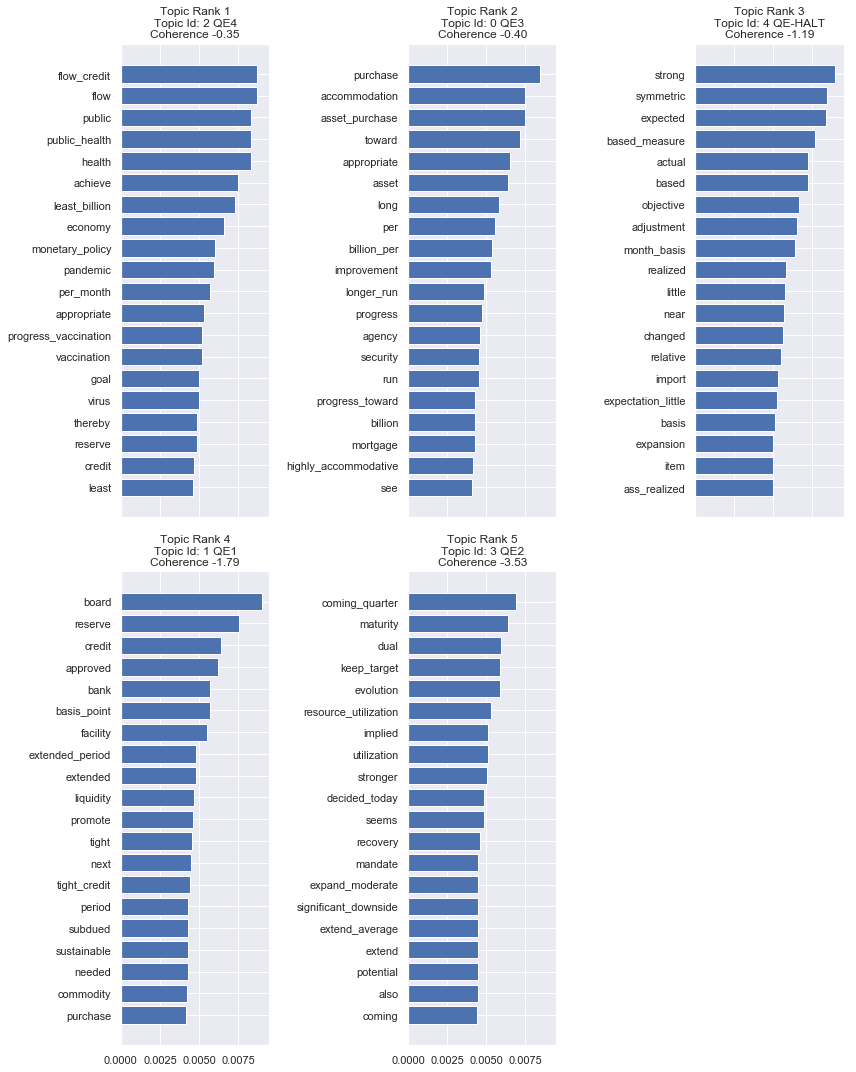

In [42]:
plot_frequency_charts()

#### Findings

What have we learned from the above frequency charts for each topic?

*   Topic (`QE4`) is associated with the economic crisis induced by the Covid pandemic.  This is evident from the use of the high frequency words: `public`, `public_health` and `pandemic`, `virus`, `vaccination`.

*   Topic (`QE3`) is associated with quantitative easing and asset purchases.  So we can confidently associated Topic 0 with Quantitative easing.  But since the FOMC has initiated multiple rounds of QE, we don't know which one the FOMC supports.   We will resolve this puzzle in the later section.

*   Topics `QE-HALT`, `QE1`, `QE2` are ambiguous because the words don't explain the topic.   Moreover, the highest frequency words are non-specific.  `strong`, `symmetric`, `board`, `reserve`, `coming_quarter`, `maturity` are the top frequency **generic** words.

We need to look at other methods to extract the topic interpretations.

#### Plotting Word Clouds

Word Clouds are even less useful than frequency charts, but they allow overlooked words to be detected.
In this case, they are uninformative.

In [43]:
def plot_wordclouds():
    topic = 0 # Initialize counter
    topic_rank = 0

    while topic < num_topics:
        # Get topics and frequencies and store in a dictionary structure
        topic_words_freq = dict(model.show_topic(topic, topn=30)) # NB. the 'dict()' constructor builds dictionaries from sequences (lists) of key-value pairs - this is needed as input for the 'generate_from_frequencies' word cloud function

        # Generate Word Cloud for topic using frequencies
        wordcloud = WordCloud(background_color="white", random_state = 15).generate_from_frequencies(topic_words_freq) 

        topic_desc = df_merge[ df_merge["topic_id"] == topic ].iat[0, 5 ]
        topic_rank = df_merge[ df_merge['topic_id'] == topic ].iat[0, 1]

        plt.title("Topic {}-{} Rank {}".format(topic , topic_desc, topic_rank))    
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        topic += 1

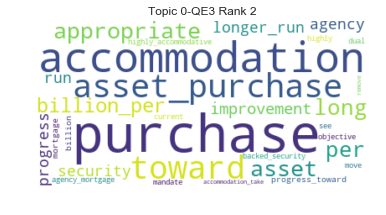

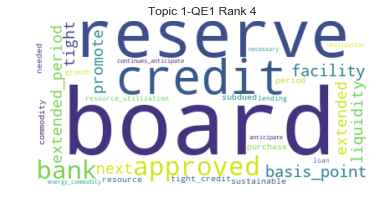

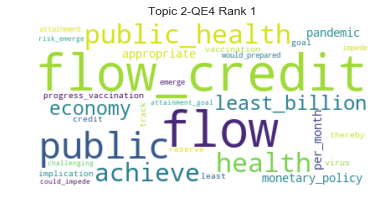

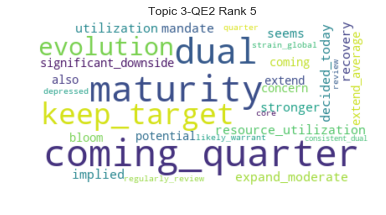

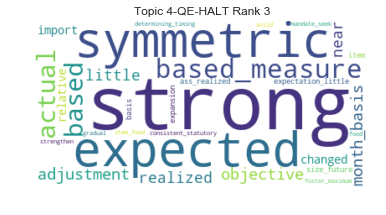

In [44]:
plot_wordclouds()



#### Time Series

Finally, we consider the time evolution of each topic within the training corpus.

Each document is assigned a set of topics and weight.  The assigned topic identifiers follow the
internal numbering convention of the model.   After obtaining the set of all topic weights for all documents,
we will construct a dataframe $X$ of dimension $D \times T$ where $X(d,t)$ is the weight of document $d$ in topic $t$.
However, when $d$ has no association with topic $t$, $X(d,t) = 0$.



In [45]:

topic_history = []

for i in range(len(trans_TFIDF)):
    list_tuples = model[trans_TFIDF[i] ]
    for v in list_tuples:
        topic_id = v[0]
        topic_weight = v[1]
        topic_history.append( dict( zip( [ "statement_id", "topic_id", "topic_weight"] ,
                                         [ (i+1), topic_id, topic_weight ] ) ) )
        #print(i , " ", topic_id , " wt: ", topic_weight )
df_topic_history = pd.DataFrame( topic_history )

df_topic_history.head()

,statement_id,topic_id,topic_weight
0,1,3,0.970152
1,2,3,0.969345
2,3,3,0.970305
3,4,3,0.971399
4,5,3,0.973179


We transform the skinny table into a $D \times T$ dataframe using `pivot_table` functionality in pandas.

In [46]:
piv_topic_history = pd.pivot_table( df_topic_history, values = 'topic_weight', index = ['statement_id'], 
                                   columns = 'topic_id' ,
                                   fill_value = 0)
piv_topic_history.columns.name=None


Next, we add the FOMC statement date column as the dataframe index and drop the previous indices.

In [47]:
piv_topic_history["date"] = pd.to_datetime( df_fomc_statements_raw["date"].tolist() )
piv_topic_history.reset_index(inplace=True)
piv_topic_history = piv_topic_history.reset_index( drop = True )
piv_topic_history.set_index('date', inplace = True )

topic_weights_hist = piv_topic_history.loc[:, piv_topic_history.columns != 'statement_id'].copy(deep=True)

topic_weights_hist.head()

,0,1,2,3,4
date,,,,,
2007-01-31,0.0,0.0,0.0,0.970152,0.0
2007-03-21,0.0,0.0,0.0,0.969345,0.0
2007-05-09,0.0,0.0,0.0,0.970305,0.0
2007-06-28,0.0,0.0,0.0,0.971399,0.0
2007-08-07,0.0,0.0,0.0,0.973179,0.0


For ease of reading, we rename the columns from the topic i to the Quantitative easing topic descriptions.

In [48]:
topic_weights_hist.rename( columns = { 0 : 'QE3' , 1 : 'QE1' , 2 : 'QE4', 3 : 'QE2' , 4 : 'QE-HALT' }, inplace =True )

In [49]:
topic_weights_hist.head()

,QE3,QE1,QE4,QE2,QE-HALT
date,,,,,
2007-01-31,0.0,0.0,0.0,0.970152,0.0
2007-03-21,0.0,0.0,0.0,0.969345,0.0
2007-05-09,0.0,0.0,0.0,0.970305,0.0
2007-06-28,0.0,0.0,0.0,0.971399,0.0
2007-08-07,0.0,0.0,0.0,0.973179,0.0


#### All Topics At Once

Before we examine each topic's history individually, we display them jointly.   A few observations are in order.

*   The topics display sharp boundary behavior.   Topics go in and out of use without significant transition.
This suggests that the LDA model is effective in detecting different subjects.

*   The topic transitions occur concurrently.  When one topic fades in importance, another topic takes over in importance.
This is consistent with the topic languages shiftly due to policy and the boiler plate language.

*   The sum of the topic weights do not exceed 100%.

*   Topic 0 (QE3) is clearly associated with quantitative easing because the highest frequency words:  `purchase`, `asset_purchase`, `accomodation`.

In [50]:
def plot_all_topic_weights():
    sns.set(rc = {'figure.figsize': (12,10) } )
    sns.set(font_scale = 2 )
    p = sns.lineplot( data=topic_weights_hist )
    p.set_ylabel( "Topic Weight" , fontsize = 15 )
    p.set_xlabel( "Year", fontsize = 15 )
    plt.title("All Topic Weights 2007-2022")
    plt.show()

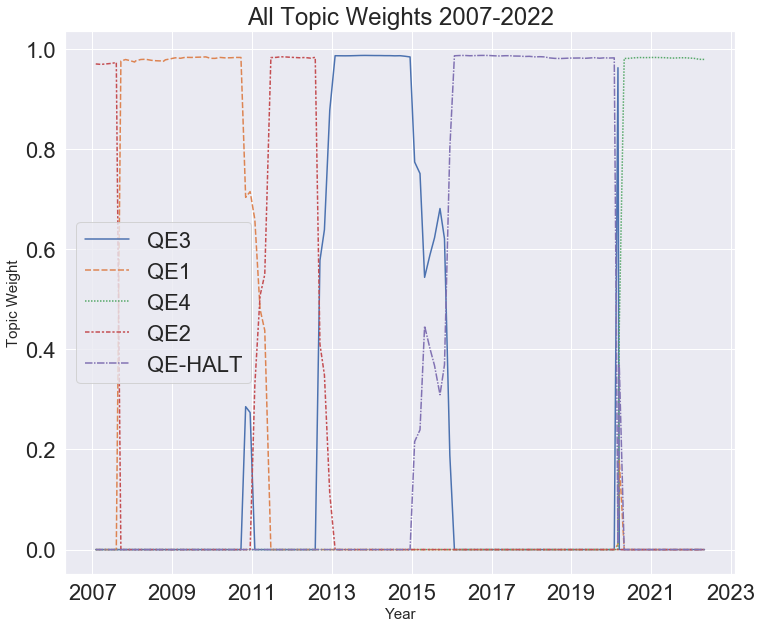

In [51]:
plot_all_topic_weights()

In [52]:
sns.set(rc = {'figure.figsize': (6,6) } )
sns.set(font_scale = 1.3 )

#for i in range(num_topics):
#    if i in set(piv_topic_history.columns):    
#        sns.lineplot( data=piv_topic_history[[i]])
#        topic_rank = df_merge[ df_merge['topic_id'] == i ].iat[0, 1]
#        plt.title("Topic {}  Rank {}".format(i, topic_rank ) )
#        plt.show()

In [53]:
def show_panel_topic_weights():

    rows = 2
    cols = math.ceil( num_topics / 2 ) 

    fig, axs = plt.subplots(nrows=rows, ncols=cols, sharex=True, figsize=(18, 12))

    for i in range(num_topics):
        if i in set(piv_topic_history.columns): 
        
            row, col = divmod(i, cols )

            ax = axs[ row, col]
            p = sns.lineplot( data=piv_topic_history[[i]], ax = ax)
            p.set_ylabel( "Topic Weight" , fontsize = 15 )
            topic_rank = df_merge[ df_merge['topic_id'] == i ].iat[0, 1]
            topic_desc = df_merge[ df_merge['topic_id'] == i ].iat[0, 5]
            ax.title.set_text("Topic {} Rank {}".format( topic_desc, topic_rank ) )
    


    plt.tight_layout()
    plt.show()

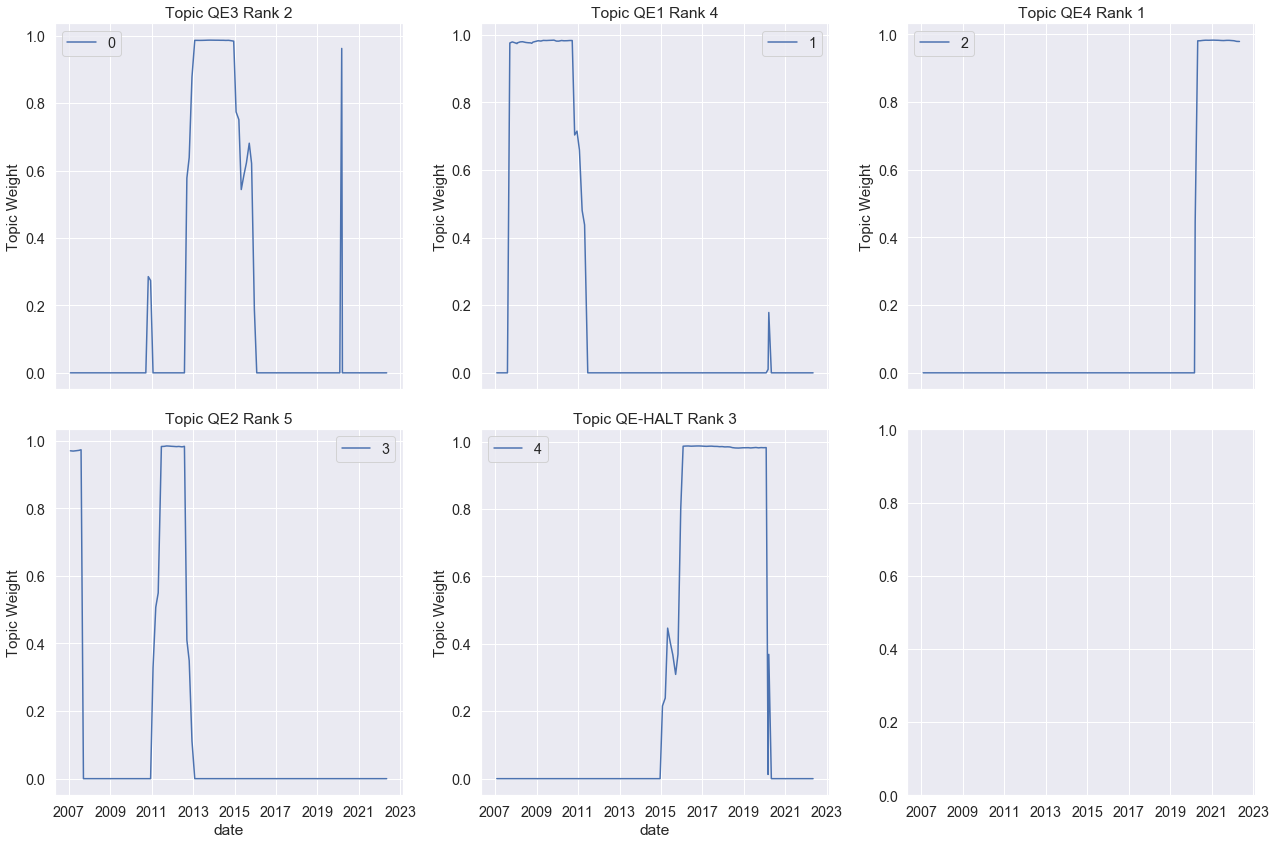

In [54]:
show_panel_topic_weights()

#### Mapping Topics to Quantitative Easing Regimes

Quantitative easing (QE) is the central bank strategy to support financial markets by buying assets using the central bank's unlimited balance sheet.
Wikipedia observes:

>Quantitative easing is an unconventional form of monetary policy, which is usually used when inflation is very low or negative, and when standard monetary policy instruments have become [ineffective.](https://en.wikipedia.org/wiki/Quantitative_easing#United_States)




This approach was necessary in the 2007-2022 period because interest rates were so low. When the Central bank hits the zero lower bound on interest rates, the bank's ability to encourage credit and investment is limited because interest rates cannot be lowered further.  

Instead, the bank has embarked on four successive waves of asset purchases called QE1, QE2, QE3 and QE4. 

See [Quantitative Easing](https://en.wikipedia.org/wiki/Quantitative_easing) for more details of the monetary policy and its implementation by major central banks. We note that there is not universal agreement on the chronology and even naming of the waves of quantitative easing. We follow the chronology and naming in Wikipedia but note that The Balance give different dates and even consider QE4 to be an extension of QE3.



The following amazing chart below from the visualcapitalist.com shows the phases and amounts of purchases with each wave of quantitative easing.
(https://www.visualcapitalist.com/the-feds-balance-sheet-the-other-exponential-curve/)





<img src="../raw/fed-balance-sheet-exponential-covid-19.jpg" width="1200" />


The table below summarizes the QE program dates when the Federal Reserve started and ended buying of assets and compares them to the dates when each topic has significant non-zero weight (typically more than 10%).


In [55]:
list_qe = [ ( 1 ,  'flow_credit, flow, public, public_health' , 'QE4' , 'March 15, 2020 - May 04, 2022' , 'March 2020 - March 2022' ) ,
            ( 2 ,  'purchase, accomodation, asset_purchase, toward' , 'QE3' , 'Sep 13, 2012-Oct 28, 2015, Mar 03, 2020' , 'Sep 2012-Oct 2014' ) ,
            ( 3 ,  'strong, symmetric, expected, based_measure' , 'QE-HALT' , 'Jan 28, 2015-Jan 29, 2020' , 'Nov 2015-Feb 2020' ) ,
            ( 4 ,  'board, reserve, credit, approved' , 'QE1' , 'Sep 18, 2007-Apr 27, 2011' , 'Nov 2008-Sep 2010' ) ,
            ( 5 ,  'coming_quarter, maturity, dual, keep_target' , 'QE2' , 'Jan 26, 2011-Oct 24, 2012' , 'Nov 2010-June 2011' ) 
          
          ]

df_qe = pd.DataFrame( data = list_qe , columns = ['Rank', 'Key Words', 'Topic' , 'LDA-Dates' , 'Actual-Dates' ] )
df_qe.reset_index( drop= True )
heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]




In [56]:
generate_topic_table = False
if generate_topic_table:
    df_qe.style.set_table_styles(dfstyle)

<img src = "../raw/QE_Topic_Table.jpg" width = "1200" />

While the high frequency words of each topic are uninformative in explaining the underlying cause of the topics, the time evolution of topic weights gives us more precise, hidden patterns.

*  The date alignment of the start of QE4 and QE3 are very close to the actual QE policy changes.   

*  The end of the QE is sometimes left clearly identified by the LDA algorithm.   

*  The halt of QE1 is not well identified.  But the entire 2007-2008 period was an extended series of increasingly severe financial market disruptions.  

*  The identification of QE2 is quite close (within 3 months).



In [57]:
from IPython.display import HTML
css_str = '<style> \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str))

### Interactive Visualization Of Topics

We also evaluate the LDA model interactively using the `pyLDAvis` package below.

The `pyLDAvis` visualization produces an intertopic distance map using MDS (multidimensionsal scaling) to produce
a principal components plot of PCA dimensions 1 and 2 (labelled `PC1`, `PC2`).    


The main conclusion from this plot is that the 𝐾=5 topic model has well-separated topics. Strong topic separation implies the model is able to distinguish topics and gives us greater confidence in the model fit. Topics are well separated when their associated circles don't overlap in the intertopic distance map. In this case, the only overlaps occur between QE1 (the circle labeled 2) and QE2 (the circle labeled 4).


In [58]:
import warnings
warnings.filterwarnings('ignore')

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare( model, trans_TFIDF , dictionary, sort_topics = False)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.004614  0.010697       1        1  23.092386
1      0.084270 -0.038917       2        1  20.731651
2     -0.004024  0.099616       3        1  13.837058
3      0.038960 -0.032001       4        1  12.748553
4     -0.123821 -0.039394       5        1  29.590352, topic_info=               Term      Freq     Total Category  logprob  loglift
114           board  3.000000  3.000000  Default  30.0000  30.0000
714     flow_credit  2.000000  2.000000  Default  29.0000  29.0000
713            flow  2.000000  2.000000  Default  28.0000  28.0000
717          public  2.000000  2.000000  Default  27.0000  27.0000
718   public_health  2.000000  2.000000  Default  26.0000  26.0000
..              ...       ...       ...      ...      ...      ...
462       objective  2.619771  4.332734   Topic5  -5.0174   0.7146
267      strengthen  1.940622  2.746975   Topic5  -5.3175   0.8702
112           basis  2.027768  3.327236   Topic5  -5.2736   0.7225
327         gradual  1.953557  2.998648   Topic5  -5.3109   0.7892
487  foster_maximum  1.843610  2.688464   Topic5  -5.3688   0.8405

[250 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
468       1  0.670613          accommodation
569       1  0.616684     accommodation_take
684       5  0.961312  accommodative_thereby
711       3  0.527189                achieve
664       5  0.897446                 actual
...     ...       ...                    ...
632       1  0.709252            view_normal
694       5  0.948916          view_realized
734       3  0.695929                  virus
374       2  0.653644                 wealth
749       3  0.749618         would_prepared

[267 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])

From the `pyLDAvis` visualization, we conclude that 

*   the topics are well separated.   A lack of overlapping circles, each of which represents a topic, tells us that the model is doing a good job in identifying distinct topics.  

*   In this case, the only overlaps occur between  `QE1` (the circle labeled 2) and `QE2` (the circle labeled 4).

The linkage between QE and topics is not visible in this analysis.

Moreover, the term bar chart is nearly equivalent in content to the earlier frequency bar charts.  

## Optimization Based on Coherence

Given our discovery that the LDA topics align with the Quantitative Easing regimes, it is not surprisingly that
topic searches higher than $K=5$ topics appear unstable below.   LDA is seeking to match topics but they become more granular.
In some cases, model coherence minimizes the U_Mass coherence but generally it seems a tenuous decision rule to calibrate the number of topics.

In [59]:
mod_results = []

for nt in [ 2, 3, 4, 5, 6, 7, 8, 9]:
     # Set training parameters.
     chunksize = 2000
     passes = 30
     iterations = 400
     eval_every = None  # Don't evaluate model perplexity, takes too much time.
     SEED = 12

     # Make an index to word dictionary.
     temp = dictionary[0]  # This is only to "load" the dictionary.
     
     ldamod = LdaModel(
          corpus=trans_TFIDF,
          id2word=id2word,
          chunksize=chunksize,
          alpha='auto',
          eta='auto',
          num_topics=nt,
          random_state = SEED ,
          passes=passes,
          eval_every=eval_every
     )
     
     cur_top_topics = ldamod.top_topics(corpus = trans_TFIDF )
     # Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
     avg_topic_coherence = sum([t[1] for t in cur_top_topics]) / nt
     #print('Average topic coherence: %.4f.' % avg_topic_coherence, "length: ", len(top_topics ) )
     
     mod_results.append( ( nt,  avg_topic_coherence ) )



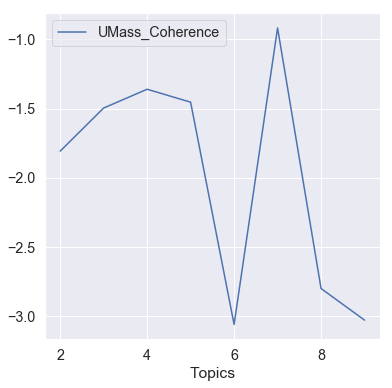

In [60]:
df_mod_results = pd.DataFrame( mod_results , columns = ['Topics', 'UMass_Coherence'] )
df_mod_results.plot(x="Topics", y = "UMass_Coherence")

### $\color{green}{\text{3.4 - Discussion}}$

When new policies about Quantitative easing are introduced, the text style of the FOMC statements appears to change.
These changes appear to be detectable by LDA.   This is consistent with the central bankers wishing to signal a change of monetary policy through a change in text style.

Does the FOMC make the textual changes intentionally?  We believe they are because the reactions of market participants can be moved by single adjective changes between consecutive statements.   Fedwatching is a highly nuanced study of subtle changes in language.


Why is LDA less accurate in detecting the end of  QE?

* curtailment of asset purchases is data dependent

* New QE policies requires more upfront explanation of scope, size and rationale

* Ending QE occurs when economic conditions are more benign.


Besides the FOMC statements, a human analyst  would examine FOMC minutes, transcripts, Beige Book, Blue Book , speeches and market commentary from other experts.  
These works would shed
insight beyond what an LDA model can provide.  However, LDA provides a concrete measurement of what an analyst may struggle to express in words, his subjective opinion of future FOMC decision making.

## $\color{blue}{\text{4 - Sentiment Analysis of FOMC Statements}}$ <a id="section4"></a>

* Preprocessing and Transformation of Corpus
    +  Tokenization
    +  Stopwords - common English language
    +  Lemmatization
   
* Application of 4 Sentiment Analysis libraries  
    +  NLTK Sentiment Intensity Analyzer
    +  TextBlob
    +  Flair
    +  PySentiment implementation of Loughran-McDonald dictionary
    
* Evaluation
    +  Visualizations of sentiment scores as time series
    +  Manual assessment of selected FOMC statements

* Regression of Sentiment Scores and Financial Variables
    +  Macroeconomic values as predictor of sentiment score
    +  Financial variables as respones of sentiment score

Given the importance and timely release of the FOMC statements, we attempt to identify a statistically significant relationship between the FOMC sentiment score and the macroeconomic conditions or financial markets variables over a multiple-day horizon during the years 2007-2022.

We generate an overall sentiment score for each statement based on 4 different Python libraries. For additional comparison purposes, we generate the score on the raw text and a transformed version of each statement.

In order to generate valid linear regression models, we calculate the difference in the sentiment score compared to the previous sentiment score, a lag of one. We also calculate a corresponding difference for the macroeconomic values and financial market variables to construct univariate linear regression models. In the end, we are unable to find a statistical significance between the change in sentiment score and the change in economic variables given a multi-day window as the markets are efficient in incorporating the impact of FOMC statements.

This section begins by preprocessing and transforming the FOMC statement corpus.  Next, we apply the 4 different Sentiment Analysis libraries to determine appropriateness of each algorithm. Next, we construct the linear regression models based on the change in sentiment score and financial variables. Lastly, after initial consideration of several variables, we focus our attention on the Wilshire variable across 25 different multi-day timeframes, but none of the linear regression models prove significant.

In [61]:
# Required imports
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from flair.models import TextClassifier
from flair.data import Sentence
import pysentiment2 as ps
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
import scipy.stats as stats
from IPython.display import Markdown as md
import warnings
warnings.filterwarnings('ignore')

In [62]:
# Read in the FOMC statements from CSV
df_fomc_stmts = pd.read_csv('../derived/FOMC_statements.csv')
df_fomc_stmts['date']= pd.to_datetime(df_fomc_stmts['date'])
df_fomc_stmts.head(3)

,statement_id,date,year,url,text,length,chairperson
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,The Federal Open Market Committee decided toda...,173,Bernanke
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,The Federal Open Market Committee decided toda...,162,Bernanke
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,The Federal Open Market Committee decided toda...,161,Bernanke


### $\color{green}{\text{ 4.1 - Data Transformation}}$

For the sentiment analysis extraction, we perform data transformations to ensure proper uniformity of the words along with common language transformations to prepare the data for the sentiment analysis algorithms.

- Lowercase all characters

- Tokenize character strings to remove punctuation

- Remove stopwords (common words of the English language)

- Lemmatize the text tokens to ensure analysis on the lemma or dictionary term

In [63]:
# Lowercase all characters
df_fomc_stmts['text'] = df_fomc_stmts['text'].astype(str).str.lower()
df_fomc_stmts.head(3)

,statement_id,date,year,url,text,length,chairperson
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,173,Bernanke
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,162,Bernanke
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,161,Bernanke


#### Tokenization

We perform straightforward tokenization of the FOMC statements, creating a list of words.

In [64]:
regexp = RegexpTokenizer('\w+')
df_fomc_stmts['text_token'] = df_fomc_stmts['text'].apply(regexp.tokenize)
df_fomc_stmts.head(3)

,statement_id,date,year,url,text,length,chairperson,text_token
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,173,Bernanke,"[the, federal, open, market, committee, decide..."
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,162,Bernanke,"[the, federal, open, market, committee, decide..."
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,161,Bernanke,"[the, federal, open, market, committee, decide..."


#### Remove Stopwords

Using the stopwords from the `NLTK` module, we remove the common English-language words. The resulting dataframe shows the word "the" removed from the `text_token` column as compared to the `text` column.

In [65]:
nltk.download('stopwords')
# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words('english')
# Use a lambda function to remove the stopwords
df_fomc_stmts['text_token'] = df_fomc_stmts['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df_fomc_stmts.head(3)

[nltk_data] Downloading package stopwords to /Volumes/GDRIVE_SSD/homes
[nltk_data]     /alex/datascience/620_WEB_ANALYTICS_2022_SPRING/nltk_d
[nltk_data]     ata...
[nltk_data]   Package stopwords is already up-to-date!


,statement_id,date,year,url,text,length,chairperson,text_token
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,173,Bernanke,"[federal, open, market, committee, decided, to..."
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,162,Bernanke,"[federal, open, market, committee, decided, to..."
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,161,Bernanke,"[federal, open, market, committee, decided, to..."


The list of words in the `text_token` column are joined to form a single character string entry.

In [66]:
# Combine text_token into one string
df_fomc_stmts['text_token'] = df_fomc_stmts['text_token'].apply(lambda x: ' '.join([item for item in x]))
df_fomc_stmts.head(3)

,statement_id,date,year,url,text,length,chairperson,text_token
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,173,Bernanke,federal open market committee decided today ke...
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,162,Bernanke,federal open market committee decided today ke...
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,161,Bernanke,federal open market committee decided today ke...


#### Lemmatization

Using the `WordNetLemmatizer` from the `NLTK` module, we lemmatize the text tokens in each FOMC statement to a common dictionary word.

In [67]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Volumes/GDRIVE_SSD/homes/a
[nltk_data]     lex/datascience/620_WEB_ANALYTICS_2022_SPRING/nltk_dat
[nltk_data]     a...
[nltk_data]   Package wordnet is already up-to-date!


True

In [68]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /Volumes/GDRIVE_SSD/homes/a
[nltk_data]     lex/datascience/620_WEB_ANALYTICS_2022_SPRING/nltk_dat
[nltk_data]     a...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [69]:
wordnet_lem = WordNetLemmatizer()
df_fomc_stmts['text_token'] = df_fomc_stmts['text_token'].apply(wordnet_lem.lemmatize)
df_fomc_stmts.head(3)

,statement_id,date,year,url,text,length,chairperson,text_token
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,173,Bernanke,federal open market committee decided today ke...
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,162,Bernanke,federal open market committee decided today ke...
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,161,Bernanke,federal open market committee decided today ke...


### $\color{green}{\text{ 4.2 - Sentiment Analysis Generation}}$

We apply the sentiment analysis to both the raw text of the FOMC statements and the transformed text tokens to allow for comparison between the two formats.

We attempt four approaches to Sentiment Analysis available in Python to generate the sentiment score for each statement.

- NLTK's Sentiment Intensity Analyzer (https://www.nltk.org/howto/sentiment.html)

- TextBlob (https://textblob.readthedocs.io/en/dev/)

- Flair (https://github.com/flairNLP/flair)

- PySentiment (https://pypi.org/project/pysentiment2)

#### NTLK Sentiment Intensity Analyzer

From `NLTK`, the `SentimentIntensityAnalyzer` produces four scores for each text: negative, neutral, positive, and compound. The `SentimentIntensityAnalyzer` relies on the VADER, Valence Aware Dictionary and sEntiment Reasoner. The VADER approach is a lexicon and rule-based sentiment analysis tool primarly developed for sentiment in social media. VADER contains a list of words with a semantic orientation as positive or negative. We use the compound score, as the metric represents a sum of all the lexicon ratings and then normalized between -1 (most negative) and 1 (most positive). 

In [70]:
analyzer = SentimentIntensityAnalyzer()
# Polarity scores
# Use the `polarity_scores` method
df_fomc_stmts['polarity'] = df_fomc_stmts['text'].apply(lambda x: analyzer.polarity_scores(x))
df_fomc_stmts.head(3)

,statement_id,date,year,url,text,length,chairperson,text_token,polarity
0,1,2007-01-31,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,173,Bernanke,federal open market committee decided today ke...,"{'neg': 0.048, 'neu': 0.897, 'pos': 0.055, 'co..."
1,2,2007-03-21,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,162,Bernanke,federal open market committee decided today ke...,"{'neg': 0.06, 'neu': 0.911, 'pos': 0.029, 'com..."
2,3,2007-05-09,2007,https://www.federalreserve.gov/newsevents/pres...,the federal open market committee decided toda...,161,Bernanke,federal open market committee decided today ke...,"{'neg': 0.06, 'neu': 0.896, 'pos': 0.044, 'com..."


Dataframe restructuring to remove extraneous column (URL) and expand the polarity score results into individual columns.

In [71]:
# Transform data
# change data structure
df_fomc_stmts = pd.concat(
    [df_fomc_stmts.drop(['url', 'polarity'], axis=1),
     df_fomc_stmts['polarity'].apply(pd.Series)], axis=1)
df_fomc_stmts.head(3)

,statement_id,date,year,text,length,chairperson,text_token,neg,neu,pos,compound
0,1,2007-01-31,2007,the federal open market committee decided toda...,173,Bernanke,federal open market committee decided today ke...,0.048,0.897,0.055,0.3122
1,2,2007-03-21,2007,the federal open market committee decided toda...,162,Bernanke,federal open market committee decided today ke...,0.060,0.911,0.029,-0.6486
2,3,2007-05-09,2007,the federal open market committee decided toda...,161,Bernanke,federal open market committee decided today ke...,0.060,0.896,0.044,-0.4019


As we are using the compound result as the overall sentiment score for each FOMC statement, we remove the negative, neutral, and positive score columns.

In [72]:
df_fomc_stmts = pd.concat(
    [df_fomc_stmts.drop(['neg', 'neu', 'pos'], axis=1)])
df_fomc_stmts.head(3)

,statement_id,date,year,text,length,chairperson,text_token,compound
0,1,2007-01-31,2007,the federal open market committee decided toda...,173,Bernanke,federal open market committee decided today ke...,0.3122
1,2,2007-03-21,2007,the federal open market committee decided toda...,162,Bernanke,federal open market committee decided today ke...,-0.6486
2,3,2007-05-09,2007,the federal open market committee decided toda...,161,Bernanke,federal open market committee decided today ke...,-0.4019


Restructure the dataframe column order and rename the compound column name to specify the text basis and the specific sentiment analyzer used.

In [73]:
cols = ['statement_id',
        'date',
        'year',
        'chairperson',
        'text',
        'compound',
        'length',
        'text_token']

In [74]:
df_fomc_stmts = df_fomc_stmts[cols]
df_fomc_stmts.rename(columns={'compound':'text_polarity_sia'}, inplace=True)
df_fomc_stmts.head(5)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,0.4588,175,federal open market committee decided today ke...
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,0.9201,204,federal open market committee decided today ke...


Now, we perform the above steps on the transformed `text_token` column.

In [75]:
#analyzer = SentimentIntensityAnalyzer()
# Polarity scores
# Use the `polarity_scores` method
df_fomc_stmts['polarity'] = df_fomc_stmts['text_token'].apply(lambda x: analyzer.polarity_scores(x))
df_fomc_stmts.head(3)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,polarity
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,"{'neg': 0.074, 'neu': 0.841, 'pos': 0.085, 'co..."
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,"{'neg': 0.093, 'neu': 0.862, 'pos': 0.045, 'co..."
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,"{'neg': 0.091, 'neu': 0.842, 'pos': 0.067, 'co..."


In [76]:
# Transform data
# change data structure
df_fomc_stmts = pd.concat(
    [df_fomc_stmts.drop(['polarity'], axis=1),
     df_fomc_stmts['polarity'].apply(pd.Series)], axis=1)
df_fomc_stmts.head(3)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,neg,neu,pos,compound
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.074,0.841,0.085,0.3122
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,0.093,0.862,0.045,-0.6486
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,0.091,0.842,0.067,-0.4019


In [77]:
df_fomc_stmts = pd.concat(
    [df_fomc_stmts.drop(['neg', 'neu', 'pos'], axis=1)])
df_fomc_stmts.head(3)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,compound
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.3122
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,-0.6486
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,-0.4019


In [78]:
df_fomc_stmts.rename(columns={'compound':'text_token_polarity_sia'}, inplace=True)
df_fomc_stmts.head(5)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,text_token_polarity_sia
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.3122
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,-0.6486
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,-0.4019
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,0.4588,175,federal open market committee decided today ke...,0.4588
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,0.9201,204,federal open market committee decided today ke...,0.9201


The resulting sentiment scores for the raw text and transformed text are quite similar, showing the `SentimentIntensityAnalyzer` works well on both sets of text for this corpus.

#### TextBlob

The `TextBlob` module follows the `Pattern` module approach to sentiment scoring. The `TextBlob` polarity score evaluates a text to -1 (most negative) to +1 (most positive). (https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis)

We apply the sentiment analysis to the raw text and the text tokens.

In [79]:
df_fomc_stmts['text_polarity_tb'] = df_fomc_stmts['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_fomc_stmts.head(5)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,text_token_polarity_sia,text_polarity_tb
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.3122,0.050769
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,-0.6486,-0.008750
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,-0.4019,0.020667
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,0.4588,175,federal open market committee decided today ke...,0.4588,0.037843
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,0.9201,204,federal open market committee decided today ke...,0.9201,0.030635


In [80]:
df_fomc_stmts['text_token_polarity_tb'] = df_fomc_stmts['text_token'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_fomc_stmts.head(5)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,text_token_polarity_sia,text_polarity_tb,text_token_polarity_tb
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.3122,0.050769,0.050769
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,-0.6486,-0.008750,-0.008750
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,-0.4019,0.020667,0.020667
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,0.4588,175,federal open market committee decided today ke...,0.4588,0.037843,0.037843
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,0.9201,204,federal open market committee decided today ke...,0.9201,0.030635,0.030635


Again, we see for the evaluation of the raw text and the transformed text, the `TextBlob` analyzer performs similarly on both sets of input.

#### Flair

The module `Flair` builds directly on PyTorch, a deep learning framework, to perform sentiment analysis. Again, we perform the sentiment analysis on the raw text and the transformed text tokens.

In [81]:
classifier = TextClassifier.load('en-sentiment')

#https://rileymjones.medium.com/sentiment-anaylsis-with-the-flair-nlp-library-cfe830bfd0f4
def predict(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    text = Sentence(sentence)
    classifier.predict(text)
    value = text.labels[0].to_dict()['value'] 
    if value == 'POSITIVE':
        result = text.labels[0].to_dict()['confidence']
    else:
        result = -(text.labels[0].to_dict()['confidence'])
    return round(result, 3)

df_fomc_stmts['text_score_fl'] = df_fomc_stmts['text'].apply(predict)
df_fomc_stmts['text_token_score_fl'] = df_fomc_stmts['text_token'].apply(predict)
df_fomc_stmts.head(5)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,text_token_polarity_sia,text_polarity_tb,text_token_polarity_tb,text_score_fl,text_token_score_fl
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.3122,0.050769,0.050769,-0.897,-0.912
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,-0.6486,-0.008750,-0.008750,-0.644,-0.911
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,-0.4019,0.020667,0.020667,-0.859,-0.931
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,0.4588,175,federal open market committee decided today ke...,0.4588,0.037843,0.037843,-0.974,-0.782
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,0.9201,204,federal open market committee decided today ke...,0.9201,0.030635,0.030635,-0.908,-0.857


The `Flair` results only return an overall assessment of the text as either positive or negative along with a confidence score. As these results do not capture the sentiment on a specific scale, the `Flair` module will not be considered for the final evaluation.

#### PySentiment

The module `PySentiment` provides two dictionaries in the library, the Harvard IV-4 and Loughran and McDonald Financial Sentiment Dictionaries, which are sentiment dictionaries for general and financial sentiment analysis. We use the the Loughran and McDonald Financial Sentiment Dictionary of the `PySentiment` module to determine the polarity of each FOMC statement. According to the `PySentiment` documentation, the polarity is calculated in the same way of the Lydia system. The formula for polarity is:

$Polarity = \frac{(postive\_words\ -\ negative\_words)}{(positive\_words\ +\ negative\_words)}$

https://sraf.nd.edu; https://pypi.org/project/pysentiment2/

In [82]:
lm = ps.LM()

def predict_lm_score(sentence):
    """ Predict the sentiment of a sentence """
    if sentence == "":
        return 0
    tokens = lm.tokenize(sentence)
    score = lm.get_score(tokens)
    #print(score)
    return round(score['Polarity'], 3)

df_fomc_stmts['text_score_lm'] = df_fomc_stmts['text'].apply(predict_lm_score)
df_fomc_stmts['text_token_score_lm'] = df_fomc_stmts['text_token'].apply(predict_lm_score)
df_fomc_stmts.head(5)

,statement_id,date,year,chairperson,text,text_polarity_sia,length,text_token,text_token_polarity_sia,text_polarity_tb,text_token_polarity_tb,text_score_fl,text_token_score_fl,text_score_lm,text_token_score_lm
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,0.3122,173,federal open market committee decided today ke...,0.3122,0.050769,0.050769,-0.897,-0.912,1.000,1.000
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,-0.6486,162,federal open market committee decided today ke...,-0.6486,-0.008750,-0.008750,-0.644,-0.911,0.000,0.000
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,-0.4019,161,federal open market committee decided today ke...,-0.4019,0.020667,0.020667,-0.859,-0.931,-0.200,-0.200
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,0.4588,175,federal open market committee decided today ke...,0.4588,0.037843,0.037843,-0.974,-0.782,0.333,0.333
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,0.9201,204,federal open market committee decided today ke...,0.9201,0.030635,0.030635,-0.908,-0.857,-0.143,-0.143


The use of the Loughran and McDonald Financial Sentiment Dictionary shows promising results in the sentiment analysis of the FOMC statements. Given the financial nature of the FOMC statements, this sentiment outcomes based on the financial sentiment dictionary was anticipated.

#### Visualizations

Next we visualize the sentiment analysis results as a time series in order to evaluate the ebb and flow of the sentiment from 2007 to 2022.

In [83]:
def  plot_sentiment_nltk_sia():

    plt.rcParams['figure.figsize'] = [15, 5]

    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_polarity_sia', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Raw Text NLTK SIA)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')
    plt.show()


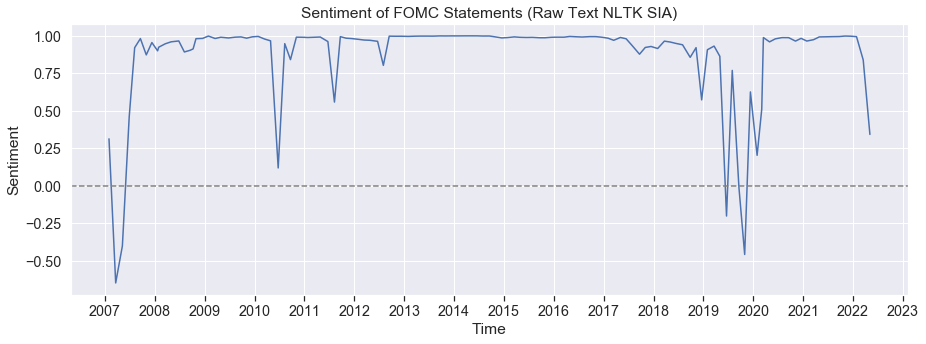

In [84]:
plot_sentiment_nltk_sia()

In [85]:
def plot_nltk_sia_tt():
    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_token_polarity_sia', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Text token NLTK SIA)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')

    plt.show()

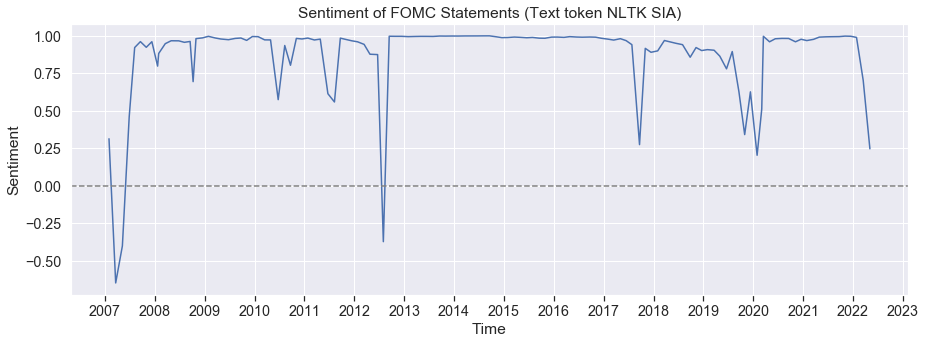

In [86]:
plot_nltk_sia_tt()

We see the `NLTK` SentimentIntensityAnalyzer provides an overall sentiment score near the extremes of the evaluation range -1 to 1.

In [87]:
def plot_textblob_rawtext():
    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_polarity_tb', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Raw Text TextBlob)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')

    plt.show()

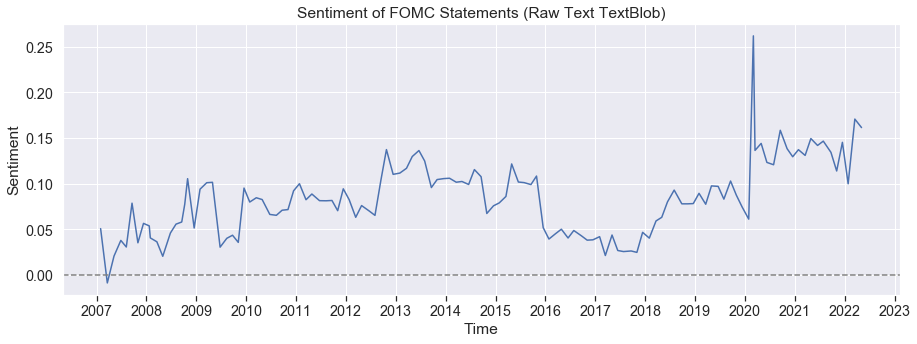

In [88]:
plot_textblob_rawtext()

In [89]:
def plot_textblob_tt():
    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_token_polarity_tb', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Text Token TextBlob)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')

    plt.show()

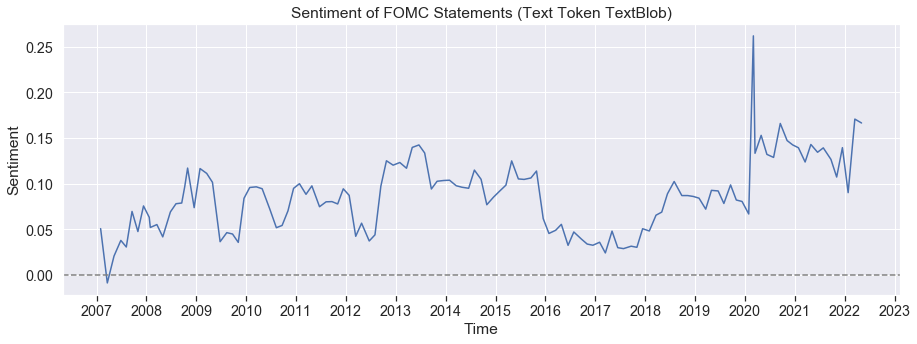

In [90]:
plot_textblob_tt()

The `TextBlob` sentiment scores indicate near always positive results which seems incongruous with the economic hardships in 2008 and the beginning of 2020.

In [91]:
def plot_flair_raw():

    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_score_fl', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Raw Text Flair)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')

    plt.show()

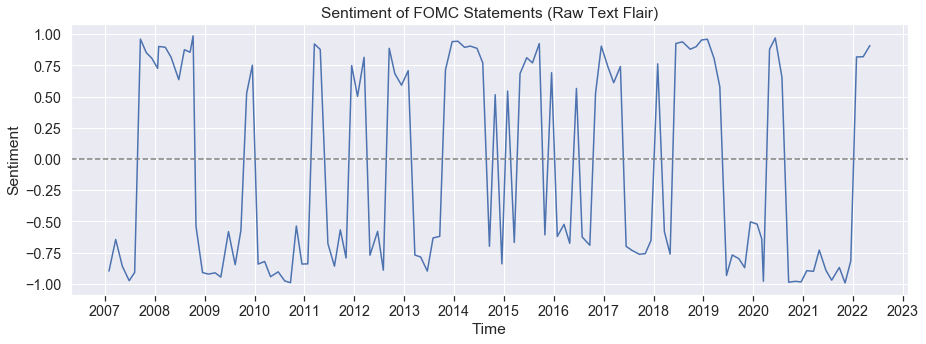

In [92]:
plot_flair_raw()

In [93]:
def plot_flair_tt():
    
    fig, g = plt.subplots()
    g = sns.lineplot(x='date', y='text_token_score_fl', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Text Token Flair)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')
    plt.show()

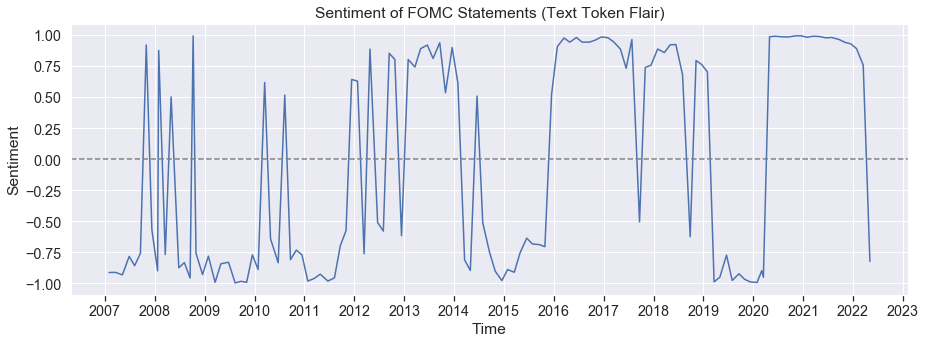

In [94]:
plot_flair_tt()

The `Flair` module produces sentiment analysis does not make sense.   

*   During the 2008 recession, Flair shows wild variations in sentiment instead of a decline.

*   During the 2020 recession, Flair shows a positive sentiment during Covid.

In [95]:
def plot_lm_raw():
    plt.rcParams['figure.figsize'] = [15, 5]

    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_score_lm', data=df_fomc_stmts)
    g.set(title='Sentiment of FOMC Statements (Raw Text Loughran McDonald)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')

    plt.show()

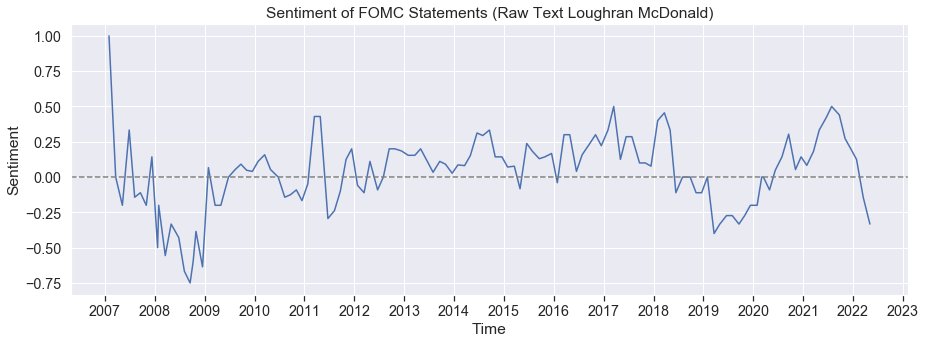

In [96]:
plot_lm_raw()

In [97]:
def plot_lm_tt():
    
    fig, g = plt.subplots()

    g = sns.lineplot(x='date', y='text_token_score_lm', data=df_fomc_stmts)
    #g.set(xticklabels=[])
    g.set(title='Sentiment of FOMC Statements (Text Token Loughran McDonald)')
    g.set(xlabel='Time')
    g.set(ylabel='Sentiment')
    g.tick_params(bottom=True)

    years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    yearsFmt = mdates.DateFormatter('%Y')

    # format the ticks
    g.xaxis.set_major_locator(years)
    g.xaxis.set_major_formatter(yearsFmt)
    #g.xaxis.set_minor_locator(months)

    g.grid(True)
    g.axhline(0, ls='--', c = 'grey')

    plt.show()

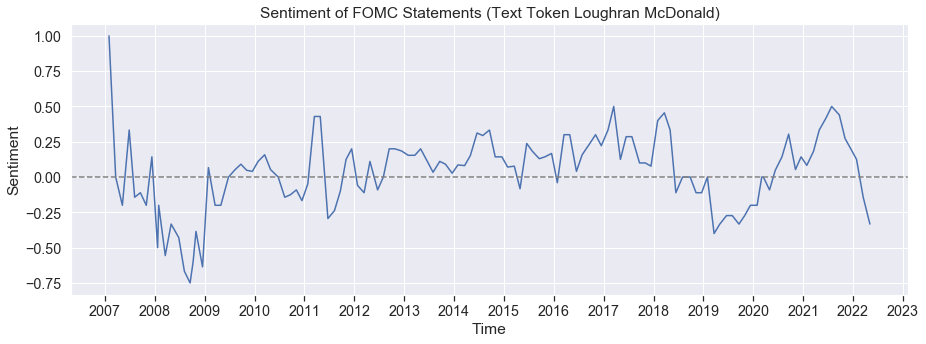

In [98]:
plot_lm_tt()

The `PySentiment` module and use of the Loughran and McDonald Financial Sentiment Dictionary generates a sentiment plot that does indicate a relationship to the economic hardships of 2008 and 2020, more inline with the expectations given the historical context.

### Evaluation

To confirm the sentiment analysis scores from the `PySentiment` module, we manually evaluate three FOMC statements, one negative, one positive, and one neutral.

#### Negative Score

The FOMC statement from September 16, 2008 received a polarity score of -0.75, the most negative score of all the statements. Given the date of the statement occurring during the financial crisis of 2008, the statement does contain an overall negative assessment of the economy at that time. The statement introduction includes the following sentences.

>Strains in financial markets have increased significantly and labor markets have weakened further. Economic growth appears to have slowed recently, partly reflecting a softening of household spending. Tight credit conditions, the ongoing housing contraction, and some slowing in export growth are likely to weigh on economic growth over the next few quarters."

The FOMC statement concludes. 
>inflation has been high, spurred by the earlier increases in the prices of energy and some other commodities. The Committee expects inflation to moderate later this year and next year, but the inflation outlook remains highly uncertain.

#### Positive Score

The July 28, 2021 FOMC statement received a polarity score of 0.5, one of three statements scoring 0.5 or above. Despite occurring during the Covid-19 pandemic, the statement does contain an overall positive tone as expressed in the following passage.

> ... with progress on vaccinations and strong policy support, indicators of economic activity and employment have continued to strengthen. The sectors most adversely affected by the pandemic have shown improvement but have not fully recovered. Inflation has risen, largely reflecting transitory factors. Overall financial conditions remain accommodative, in part reflecting policy measures to support the economy and the flow of credit to U.S. households and businesses.

#### Neutral Score
The September 16, 2018 FOMC statement received a polarity score of 0.0, one of nine statements to do so. The neutral tone is exemplified in sentences such as

>on a 12-month basis, both overall inflation and inflation for items other than food and energy remain near 2 percent. Indicators of longer-term inflation expectations are little changed, on balance.

The statement also includes a neutral outlook with the inclusion of "risks to the economic outlook appear roughly balanced."

#### Assessment

The `PySentiment` module, based on the Loughran and McDonald Financial Sentiment Dictionary, appears to evaluate the sentiment accurately for the FOMC statements.

Focused on the `PySentiment` scores, let's confirm there is no difference in the sentiment evaluation between the raw text and the text tokens.

In [99]:
sum(df_fomc_stmts['text_score_lm'] - df_fomc_stmts['text_token_score_lm'])

0.0

The results show no difference between the two text formats. This analysis does not evaluate one approach over the other, but confirms either set of results can be used to apply the linear regression models against the economic indices over the same time period.

### $\color{green}{\text{ 4.3 - Specifying the Regressions}}$

We implement the dataframes containing the variables to be regressed below.

* The sentiment indicator is put into a dataframe called `df_sentiment`

* The market variables to be regressed are aligned by date.

We use the pandas `merge_asof` to do approximate date matching correctly.


Its logic aligns each FOMC date to the closest prior date of each other published financial or economic time series. 

Each univariate regression is displayed below for analysis using a scatterplot in addition to the residuals plot for each univariate regression.

In [100]:
# Retrieve the sentiment scores produced from running the Loughran-McDonald financial library on the FOMC statements
derived_data_dir = "../derived"
fomc_statements_file = derived_data_dir + "/" + "FOMC_statements_with_sentiment_score.csv"
df_fomc_statements_raw = pd.read_csv( fomc_statements_file , parse_dates=[1], header = 0)
df_fomc_statements_raw.head(5)

,statement_id,date,year,chairperson,text,length,text_token,text_token_score_lm,score_lm_diff
0,1,2007-01-31,2007,Bernanke,the federal open market committee decided toda...,173,federal open market committee decided today ke...,1.000,NaN
1,2,2007-03-21,2007,Bernanke,the federal open market committee decided toda...,162,federal open market committee decided today ke...,0.000,-1.000
2,3,2007-05-09,2007,Bernanke,the federal open market committee decided toda...,161,federal open market committee decided today ke...,-0.200,-0.200
3,4,2007-06-28,2007,Bernanke,the federal open market committee decided toda...,175,federal open market committee decided today ke...,0.333,0.533
4,5,2007-08-07,2007,Bernanke,the federal open market committee decided toda...,204,federal open market committee decided today ke...,-0.143,-0.476


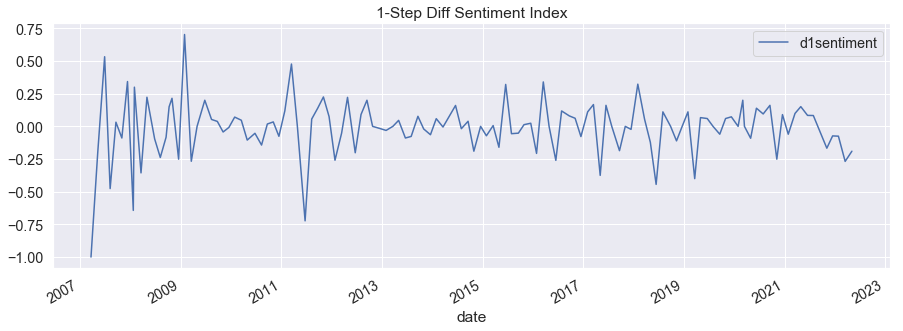

In [101]:
# Extract the column from the input that represents the Loughran-McDonald sentiment score
df_sentiment = pd.DataFrame( df_fomc_statements_raw["date"] )
df_sentiment["sentiment"] = df_fomc_statements_raw["text_token_score_lm"]

# Calculate the difference from previous row
df_sentiment[ "d1sentiment" ] = df_sentiment["sentiment"].diff( periods = 1 )
df_sentiment

# Plot the sentiment score difference as a time series
df_sentiment.plot(x = "date", y = "d1sentiment")
plt.title("1-Step Diff Sentiment Index")
plt.show()

First, we plot the sentiment analysis difference to confirm the data has a near uniform range and a mean near zero - applicable for a linear regression model.

### Regression

For each of the financial variables we generate a univariate linear regression model based on a one-lag difference in the sentiment scores and an appropriate lag size for the financial variables. As the sentiment score and the financial variables are time series datasets, we must take the difference at meaningful intervals in order to generate a valid linear regression model. We use the `ols` function, estimation by ordinary least squares, from the `statsmodels` module to build the linear regression models. We display the summary statistics for the linear regression model using the `summary` function from the `statsmodels` model fit. 

We track the $R^2$ value of each model fit, the independent variable coefficient, and the P-value for the coefficient value for comparison across all the linear regression models.

#### Approach

Let the sentiment variable be denoted as $Z$.

For macroeconomic variables $Y$: we estimate the model $Z = f(Y)$.
- We explain the sentiment variable in terms of macroeconomic variable.

For financial market variable $X$:  we estimate the model $X = g(Z)$.
- We explain the financial variable in terms of sentiment variable.

Date Alignment for macroeconomic model fit: for each FOMC date $f(i)$ and the prior FOMC meeting date $f(i-1)$ find the macroeconomic variable for the same month and year.

We estimate a model based on the change in sentiment $Z[f(i)] - Z[f(i-1)]$

We compare the sentiment variable to the prior change in macroeconomic `bd1` (backward difference of 1 lag) or `bp12` (backward proportional change over 12 months).

### Macroeconomic Variables

#### CIVPART

The linear regression model explains the FOMC statement sentiment score in terms of the Labor Force Participation Rate. For this financial variable, we use a backward difference of 1 lag - `bd1`.

In [102]:
CIVPART = dict_series["CIVPART"]
df_sent_CIVPART = pd.merge_asof(df_sentiment, CIVPART, left_on = "date", right_on = "DATE")

def plot_civpart_bd1():


    #print(df_sent_CIVPART.tail(10) )

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( y= 'd1sentiment', x = "bd1", data = df_sent_CIVPART, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")
    sns.residplot(y= 'd1sentiment', x = "bd1", data = df_sent_CIVPART, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")
    fig.suptitle("CIVPART vs Sentiment (Changes)")
    plt.show()


# Generate linear regression model
mod_CIVPART_bd1 = sm.OLS(df_sent_CIVPART['d1sentiment'], sm.add_constant(df_sent_CIVPART['bd1']), missing='drop')
mod_fit_CIVPART_bd1 = mod_CIVPART_bd1.fit()


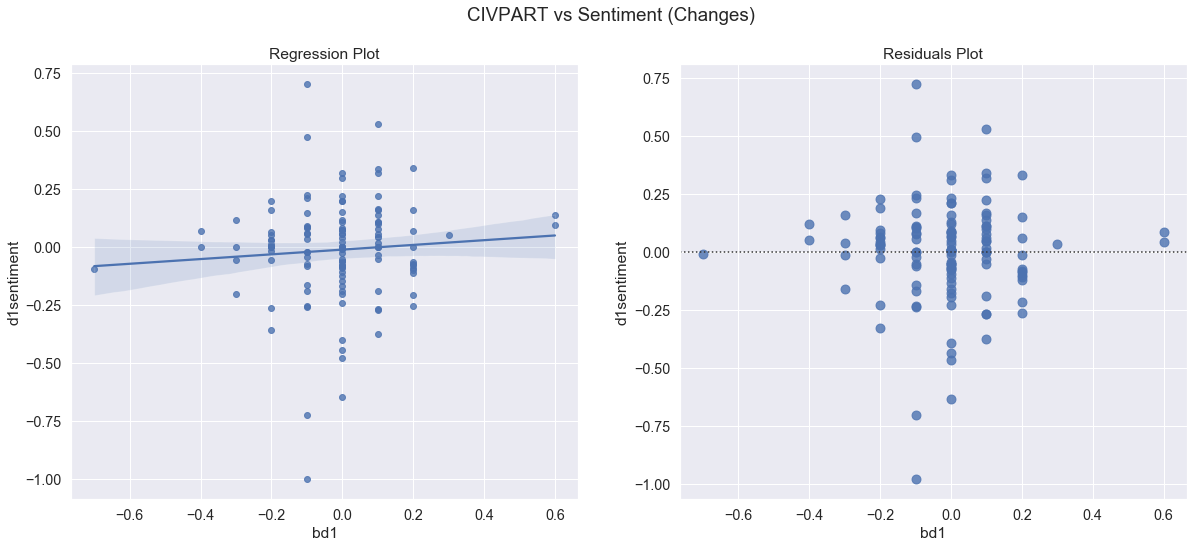

In [103]:
plot_civpart_bd1()

In [104]:
print(mod_fit_CIVPART_bd1.summary())

                            OLS Regression Results                            
Dep. Variable:            d1sentiment   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.7507
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.388
Time:                        21:35:08   Log-Likelihood:                 13.760
No. Observations:                 125   AIC:                            -23.52
Df Residuals:                     123   BIC:                            -17.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0095      0.020     -0.486      0.6

In [105]:
mod_CIVPART_bd1_r2 = mod_fit_CIVPART_bd1.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_CIVPART_bd1_r2))

The model's R-squared value: 0.006.

In [106]:
mod_CIVPART_bd1_var_coef = mod_fit_CIVPART_bd1.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_CIVPART_bd1_var_coef))

The coefficient of independent variable: 0.102.

In [107]:
mod_CIVPART_bd1_pval = mod_fit_CIVPART_bd1.pvalues['bd1']
md("The P-value of independent variable: {:.3f}.".format(mod_CIVPART_bd1_pval))

The P-value of independent variable: 0.388.

The resulting $R^2$ value is 0.006. The very low result shows the variance in the sentiment score explains essentially none of the variance in the dependent variable.

The coefficient for the backward difference variable is 0.102 with a P-value of over 35% indicating we cannot reject the null hypothesis. This indicates there is 61% probability of being correct that the variable is having some effect much lower than the 95% significance level.

#### UNRATE

This model explains the FOMC statement sentiment score in terms of the U-3 measure of labor unemployment as published monthly by the Bureau of Labor Statistics (BLS). For this financial variable, we use a backward difference of 1 lag - `bd1`.

In [108]:
UNRATE = dict_series["UNRATE"]

df_sent_UNRATE = pd.merge_asof(df_sentiment, UNRATE, left_on = "date", right_on = "DATE")

#print(df_sent_UNRATE.tail(10) )
def plot_unrate_bd1():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( y= 'd1sentiment', x = "bd1", data = df_sent_UNRATE, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")
    sns.residplot( y= 'd1sentiment', x = "bd1", data = df_sent_UNRATE, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")
    fig.suptitle("UNRATE vs Sentiment (Changes)")
    plt.show()

# Generate linear regression model
mod_UNRATE_bd1 = sm.OLS(df_sent_UNRATE['d1sentiment'], sm.add_constant(df_sent_UNRATE['bd1']), missing='drop')
mod_fit_UNRATE_bd1 = mod_UNRATE_bd1.fit()


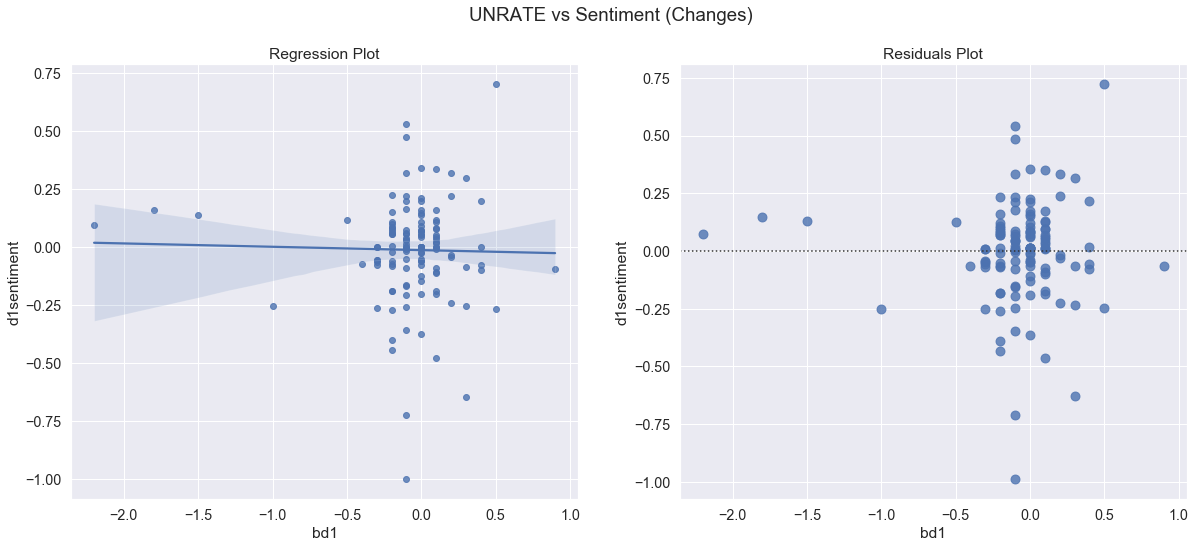

In [109]:
plot_unrate_bd1()

In [110]:
print(mod_fit_UNRATE_bd1.summary())

                            OLS Regression Results                            
Dep. Variable:            d1sentiment   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                   0.06733
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.796
Time:                        21:35:08   Log-Likelihood:                 13.414
No. Observations:                 125   AIC:                            -22.83
Df Residuals:                     123   BIC:                            -17.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0116      0.020     -0.583      0.5

In [111]:
mod_UNRATE_bd1_r2 = mod_fit_UNRATE_bd1.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_UNRATE_bd1_r2))

The model's R-squared value: 0.001.

In [112]:
mod_UNRATE_bd1_var_coef = mod_fit_UNRATE_bd1.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_UNRATE_bd1_var_coef))

The coefficient of independent variable: -0.014.

In [113]:
mod_UNRATE_bd1_pval = mod_fit_UNRATE_bd1.pvalues['bd1']
md("The P-value of independent variable: {:.3f}.".format(mod_UNRATE_bd1_pval))

The P-value of independent variable: 0.796.

The resulting $R^2$ value is 0.001 indicates little relationship between the two variables. The coefficient for the backward difference variable is -0.014 with a P-value of almost 80% indicating we cannot reject the null hypothesis.

#### PCEPILFE

This model explains the FOMC statement sentiment score in terms of the Personal Consumption Expenditures Excluding Food and Energy. For this financial variable, we use a backward proportional change of 12 months - `bp12`.

In [114]:
PCEPILFE = dict_series["PCEPILFE"]

df_sent_PCEPILFE = pd.merge_asof(df_sentiment, PCEPILFE, left_on = "date", right_on = "DATE")

def plot_pce_bd1():

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( y= 'd1sentiment', x = "bp12", data = df_sent_PCEPILFE, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")
    sns.residplot( y= 'd1sentiment', x = "bp12", data = df_sent_PCEPILFE, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")
    fig.suptitle("Annualized PCEILFE vs Sentiment (Changes)")
    plt.show()

# Generate linear regression model
mod_PCEPILFE_bp12 = sm.OLS(df_sent_PCEPILFE['d1sentiment'], sm.add_constant(df_sent_PCEPILFE['bp12']), missing='drop')
mod_fit_PCEPILFE_bp12 = mod_PCEPILFE_bp12.fit()
#print(mod_fit_PCEPILFE_bp12.summary())

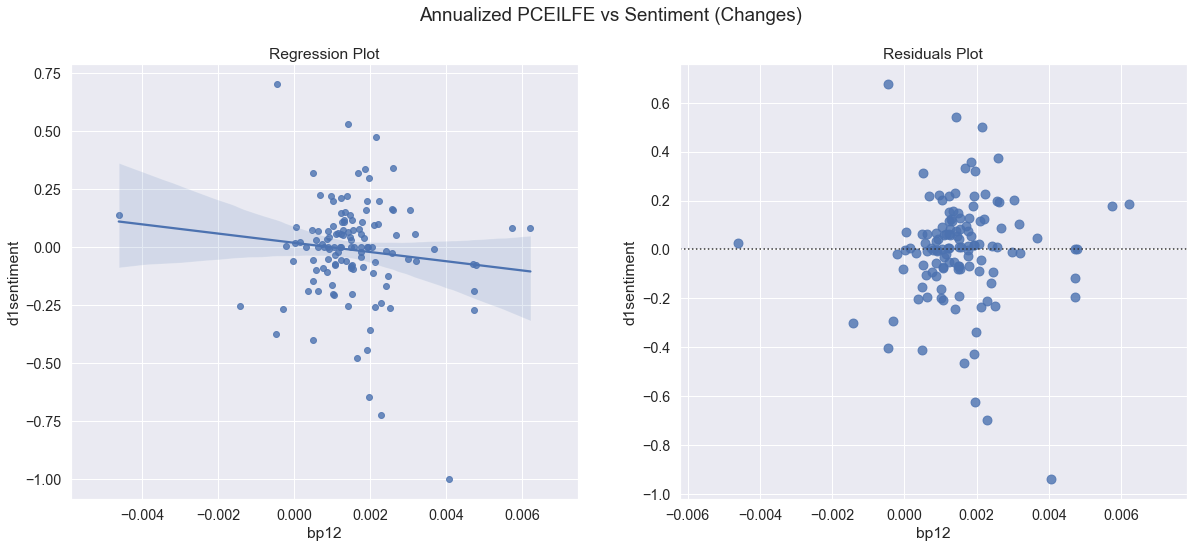

In [115]:
plot_pce_bd1()

In [116]:
print(mod_fit_PCEPILFE_bp12.summary())

                            OLS Regression Results                            
Dep. Variable:            d1sentiment   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1.739
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.190
Time:                        21:35:08   Log-Likelihood:                 14.257
No. Observations:                 125   AIC:                            -24.51
Df Residuals:                     123   BIC:                            -18.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.030      0.659      0.5

In [117]:
mod_PCEPILFE_bp12_r2 = mod_fit_PCEPILFE_bp12.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_PCEPILFE_bp12_r2))

The model's R-squared value: 0.014.

In [118]:
mod_PCEPILFE_bp12_var_coef = mod_fit_PCEPILFE_bp12.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_PCEPILFE_bp12_var_coef))

The coefficient of independent variable: -19.888.

In [119]:
mod_PCEPILFE_bp12_pval = mod_fit_PCEPILFE_bp12.pvalues['bp12']
md("The P-value of independent variable: {:.3f}.".format(mod_PCEPILFE_bp12_pval))

The P-value of independent variable: 0.190.

The resulting $R^2$ value is 0.014 indicates little relationship between the two variables. The coefficient for the backward difference variable is -19.888 with a P-value of 19% indicating we cannot reject the null hypothesis.

### Financial Market Variables

Date Alignment for financial model fit: for each FOMC date $f(i)$, we find the financial variable for the date. Most variables are available daily. We estimate a model on the change in the financial variable as a result of the change in sentiment.

One important problem is that FOMC statement is released during the market hours at 2pm EST. Thus, the financial variable recorded at end of day on the same day as the FOMC statement already reflects the sentiment impact. Therefore, we need to compare the change in response of the financial variable across a date before the FOMC statement versus 1 or more days after the FOMC statement.


We use 2 comparison periods to measure the change:

    fp2: change from 1 day before FOMC date to 1 day after the FOMC date, a forward propogation of 2
    fp5: change from 1 day before FOMC date to 4 days after the FOMC date, a forward propogation of 5

For ease of date alignment, we shifted both fp2 and fp5 by 1 day forward. So the value of fp2 and fp5 on a FOMC date is actually spanning the intended time period.

#### BAA10Y

This model explains the Moody's Seasoned Baa Corporate Bond yield relative to yield on 10-year Treasury Constant Maturities in terms of the the sentiment score.

#### Two-Day Difference (fp2)

In [120]:
BAA10Y = dict_series["BAA10Y"]

df_sent_BAA10Y = pd.merge_asof(df_sentiment, BAA10Y, left_on = "date", right_on = "DATE")

def plot_BAA10Y_fp2():

    #print(df_sent_BAA10Y.tail(10) )

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( x= 'd1sentiment', y = "fp2", data = df_sent_BAA10Y, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")
    sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_BAA10Y, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")
    fig.suptitle("AA10Y 2-day vs Sentiment (Changes)")
    plt.show()

# Generate linear regression model
mod_BAA10Y_fp2 = sm.OLS(df_sent_BAA10Y['fp2'], sm.add_constant(df_sent_BAA10Y['d1sentiment']), missing='drop')
mod_fit_BAA10Y_fp2 = mod_BAA10Y_fp2.fit()


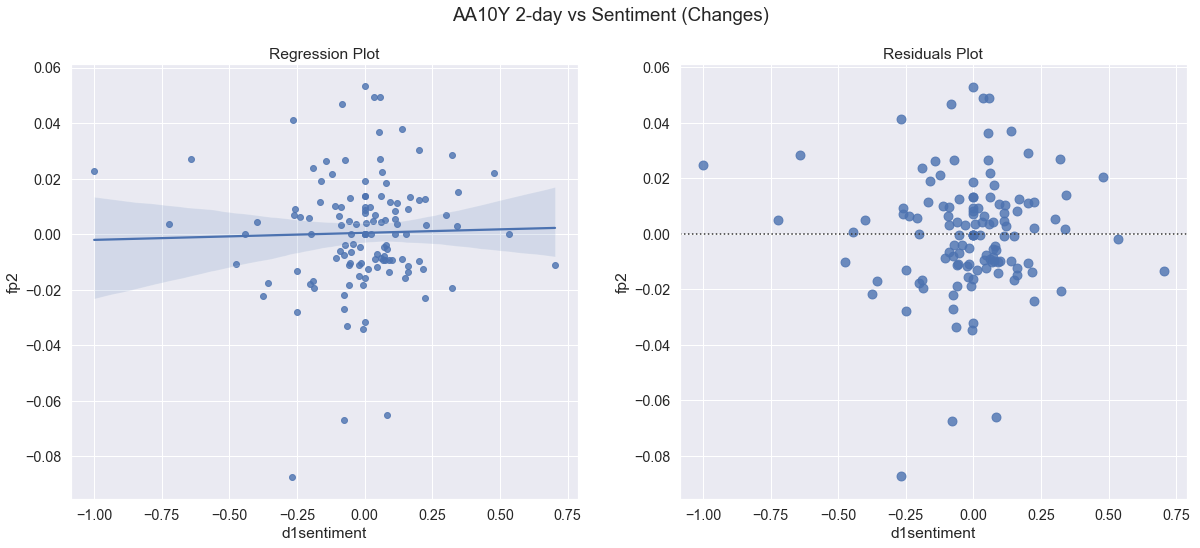

In [121]:
plot_BAA10Y_fp2()

In [122]:
print(mod_fit_BAA10Y_fp2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.08551
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.770
Time:                        21:35:09   Log-Likelihood:                 306.50
No. Observations:                 125   AIC:                            -609.0
Df Residuals:                     123   BIC:                            -603.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0005      0.002      0.261      

In [123]:
mod_BAA10Y_fp2_r2 = mod_fit_BAA10Y_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_BAA10Y_fp2_r2))

The model's R-squared value: 0.001.

In [124]:
mod_BAA10Y_fp2_var_coef = mod_fit_BAA10Y_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_BAA10Y_fp2_var_coef))

The coefficient of independent variable: 0.003.

In [125]:
mod_BAA10Y_fp2_pval = mod_fit_BAA10Y_fp2.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_BAA10Y_fp2_pval))

The P-value of independent variable: 0.770.

#### Five-Day Difference (fp5)

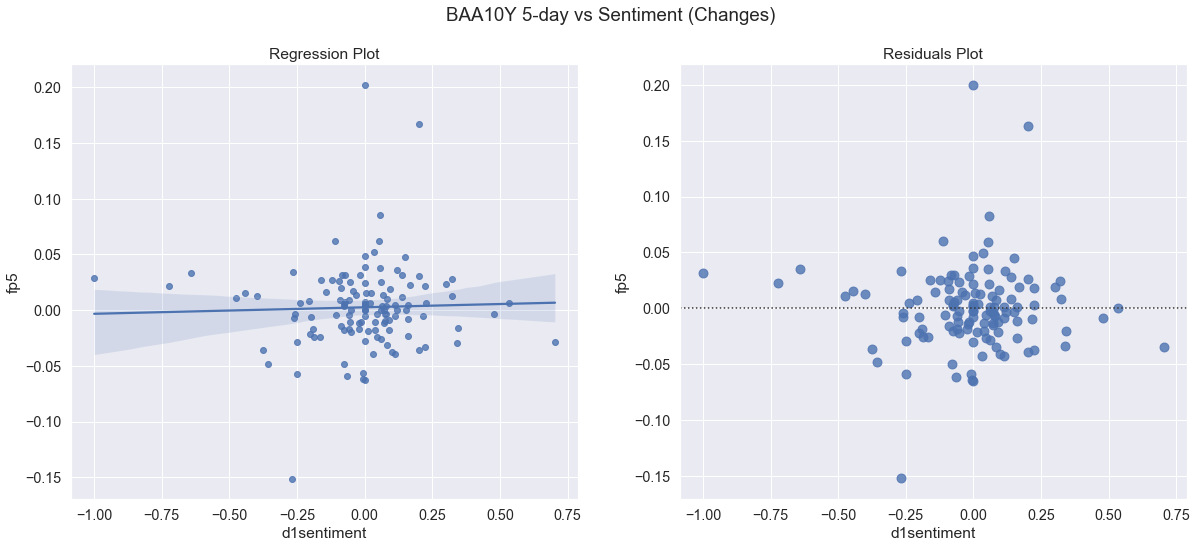

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                    0.1371
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.712
Time:                        21:35:09   Log-Likelihood:                 229.84
No. Observations:                 124   AIC:                            -455.7
Df Residuals:                     122   BIC:                            -450.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0026      0.003      0.751      

In [126]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.regplot( x= 'd1sentiment', y = "fp5", data = df_sent_BAA10Y, fit_reg=True, ax=ax1)
ax1.set_title("Regression Plot")
sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_BAA10Y, scatter_kws={"s": 80}, ax=ax2)
ax2.set_title("Residuals Plot")
fig.suptitle("BAA10Y 5-day vs Sentiment (Changes)")
plt.show()

# Generate linear regression model
mod_BAA10Y_fp5 = sm.OLS(df_sent_BAA10Y['fp5'], sm.add_constant(df_sent_BAA10Y['d1sentiment']), missing='drop')
mod_fit_BAA10Y_fp5 = mod_BAA10Y_fp5.fit()
print(mod_fit_BAA10Y_fp5.summary())

In [127]:
# fp5
mod_BAA10Y_fp5_r2 = mod_fit_BAA10Y_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_BAA10Y_fp5_r2))

The model's R-squared value: 0.001.

In [128]:
mod_BAA10Y_fp5_var_coef = mod_fit_BAA10Y_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_BAA10Y_fp5_var_coef))

The coefficient of independent variable: 0.006.

In [129]:
mod_BAA10Y_fp5_pval = mod_fit_BAA10Y_fp5.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_BAA10Y_fp5_pval))

The P-value of independent variable: 0.712.

The sentiment variable, in neither the `fp2` model nor the `fp5` model, explains the variance in the financial variable as both models result in an $R^2$ of 0.001 and a coefficient P-value greater than 70%.

#### T10YIE

This model explains the breakeven inflation rate in terms of the the sentiment score.

#### Two-Day Difference (fp2)

In [130]:
T10YIE = dict_series["T10YIE"]

df_sent_T10YIE = pd.merge_asof(df_sentiment, T10YIE, left_on = "date", right_on = "DATE")

def plot_T10YIE_fp2():

    #print(df_sent_T10YIE.tail(10) )

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( x= 'd1sentiment', y = "fp2", data = df_sent_T10YIE, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")
    sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_T10YIE, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")
    fig.suptitle("T10YIE 2-day vs Sentiment (Changes)")
    plt.show()

# Generate linear regression model
mod_T10YIE_fp2 = sm.OLS(df_sent_T10YIE['fp2'], sm.add_constant(df_sent_T10YIE['d1sentiment']), missing='drop')
mod_fit_T10YIE_fp2 = mod_T10YIE_fp2.fit()


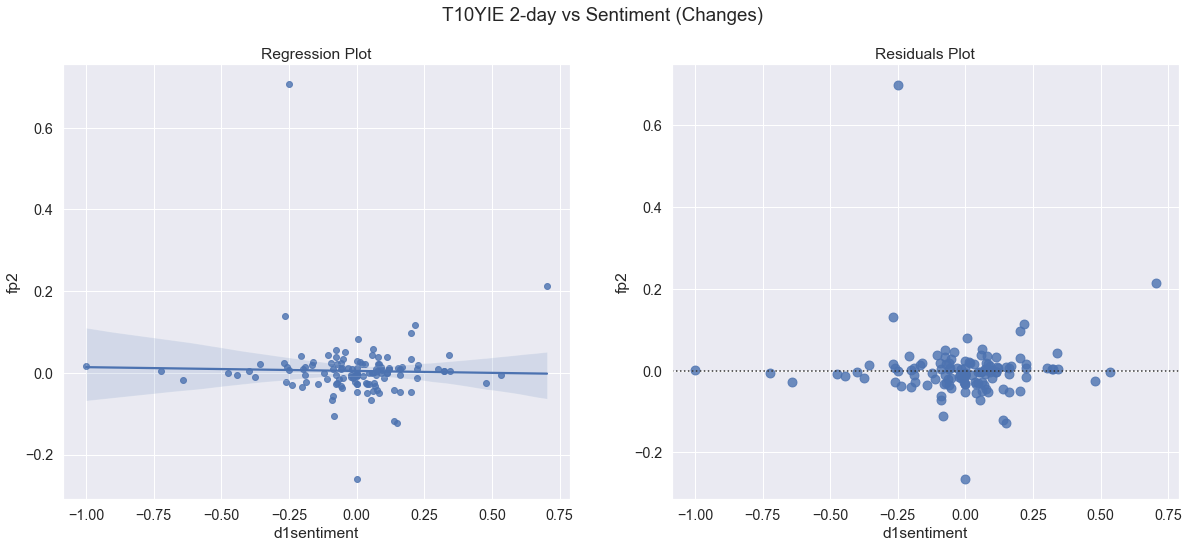

In [131]:
plot_T10YIE_fp2()

In [132]:
print(mod_fit_T10YIE_fp2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.007
Method:                 Least Squares   F-statistic:                   0.08128
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.776
Time:                        21:35:10   Log-Likelihood:                 140.28
No. Observations:                 125   AIC:                            -276.6
Df Residuals:                     123   BIC:                            -270.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0047      0.007      0.664      

In [133]:
mod_T10YIE_fp2_r2 = mod_fit_T10YIE_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_T10YIE_fp2_r2))

The model's R-squared value: 0.001.

In [134]:
mod_T10YIE_fp2_var_coef = mod_fit_T10YIE_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_T10YIE_fp2_var_coef))

The coefficient of independent variable: -0.009.

In [135]:
mod_T10YIE_fp2_pval = mod_fit_T10YIE_fp2.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_T10YIE_fp2_pval))

The P-value of independent variable: 0.776.

#### Five-Day Difference (fp5)

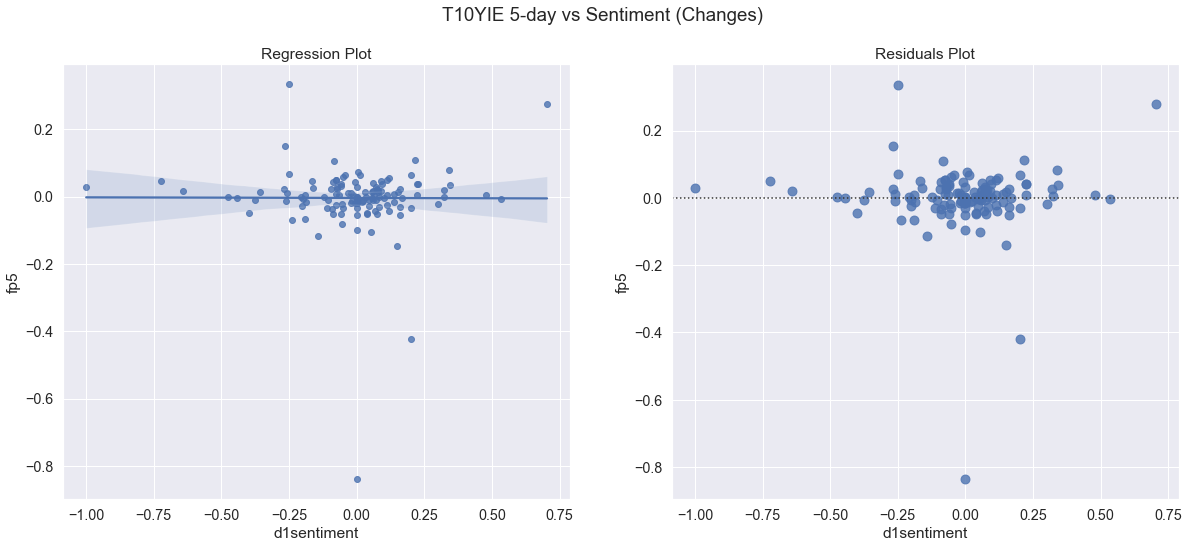

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.001861
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.966
Time:                        21:35:10   Log-Likelihood:                 108.03
No. Observations:                 125   AIC:                            -212.1
Df Residuals:                     123   BIC:                            -206.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0040      0.009     -0.433      

In [136]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.regplot( x= 'd1sentiment', y = "fp5", data = df_sent_T10YIE, fit_reg=True, ax=ax1)
ax1.set_title("Regression Plot")
sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_T10YIE, scatter_kws={"s": 80}, ax=ax2)
ax2.set_title("Residuals Plot")
fig.suptitle("T10YIE 5-day vs Sentiment (Changes)")
plt.show()

# Generate linear regression model
mod_T10YIE_fp5 = sm.OLS(df_sent_T10YIE['fp5'], sm.add_constant(df_sent_T10YIE['d1sentiment']), missing='drop')
mod_fit_T10YIE_fp5 = mod_T10YIE_fp5.fit()
print(mod_fit_T10YIE_fp5.summary())

In [137]:
mod_T10YIE_fp5_r2 = mod_fit_T10YIE_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_T10YIE_fp5_r2))

The model's R-squared value: 0.000.

In [138]:
mod_T10YIE_fp5_var_coef = mod_fit_T10YIE_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_T10YIE_fp5_var_coef))

The coefficient of independent variable: -0.002.

In [139]:
mod_T10YIE_fp5_pval = mod_fit_T10YIE_fp5.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_T10YIE_fp5_pval))

The P-value of independent variable: 0.966.

Again, the sentiment variable, in neither the `fp2` model nor the `fp5` model, explains the variance in the financial variable as both models result in an $R^2$ of zero and a coefficient P-value greater than 75%.

#### WILL5000IND

This model explains the total returns of the Wilshire 5000 Stock Index in terms of the the sentiment score.

#### Two-Day Difference (fp2)

In [140]:
WILL5000IND = dict_series["WILL5000IND"]

df_sent_WILL5000IND = pd.merge_asof(df_sentiment, WILL5000IND, left_on = "date", right_on = "DATE")

def plot_WILL5000IND_fp2():

    #print(df_sent_WILL5000IND.tail(10) )

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( x= 'd1sentiment', y = "fp2", data = df_sent_WILL5000IND, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")
    sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_WILL5000IND, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")
    fig.suptitle("WILL5000IND 2-day vs Sentiment (Changes)")
    plt.show()

# Generate linear regression model
mod_WILL5000IND_fp2 = sm.OLS(df_sent_WILL5000IND['fp2'], sm.add_constant(df_sent_WILL5000IND['d1sentiment']), missing='drop')
mod_fit_WILL5000IND_fp2 = mod_WILL5000IND_fp2.fit()


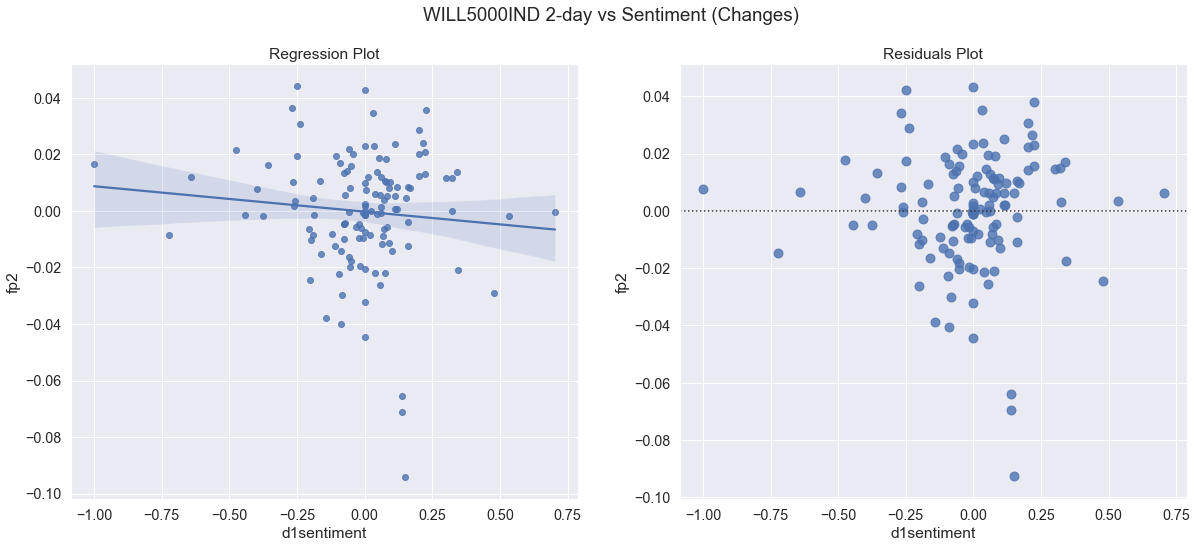

In [141]:
plot_WILL5000IND_fp2()

In [142]:
print(mod_fit_WILL5000IND_fp2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.126
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.291
Time:                        21:35:10   Log-Likelihood:                 308.91
No. Observations:                 125   AIC:                            -613.8
Df Residuals:                     123   BIC:                            -608.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0003      0.002     -0.137      

In [143]:
#fp2
mod_WILL5000IND_fp2_r2 = mod_fit_WILL5000IND_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_WILL5000IND_fp2_r2))

The model's R-squared value: 0.009.

In [144]:
mod_WILL5000IND_fp2_var_coef = mod_fit_WILL5000IND_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_WILL5000IND_fp2_var_coef))

The coefficient of independent variable: -0.009.

In [145]:
mod_WILL5000IND_fp2_pval = mod_fit_WILL5000IND_fp2.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_WILL5000IND_fp2_pval))

The P-value of independent variable: 0.291.

#### Five-Day Difference (fp5)

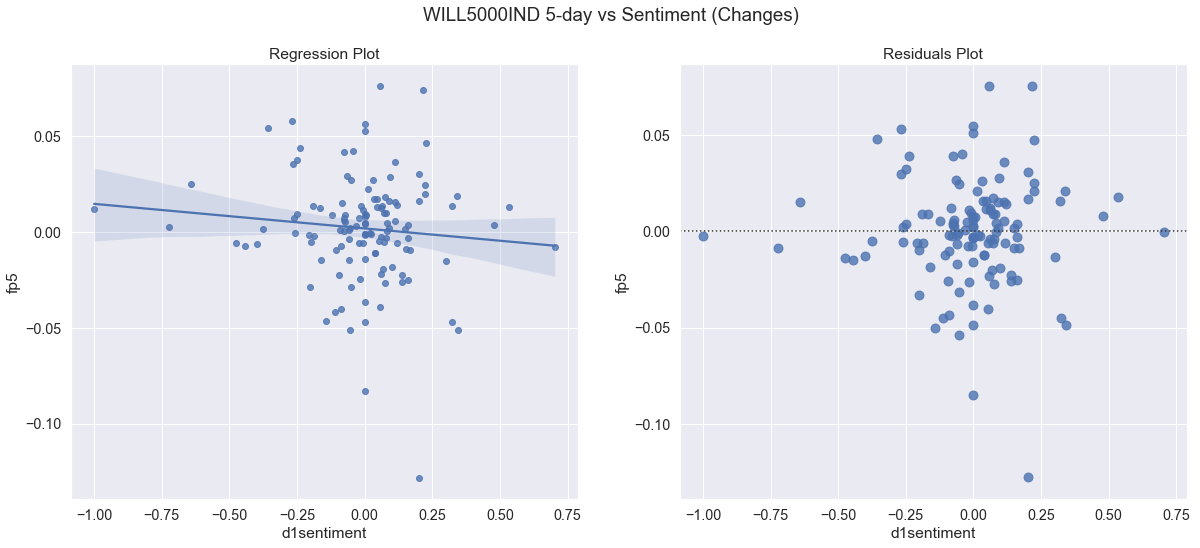

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.243
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.267
Time:                        21:35:11   Log-Likelihood:                 268.82
No. Observations:                 124   AIC:                            -533.6
Df Residuals:                     122   BIC:                            -528.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0019      0.003      0.763      

In [146]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.regplot( x= 'd1sentiment', y = "fp5", data = df_sent_WILL5000IND, fit_reg=True, ax=ax1)
ax1.set_title("Regression Plot")
sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_WILL5000IND, scatter_kws={"s": 80}, ax=ax2)
ax2.set_title("Residuals Plot")
fig.suptitle("WILL5000IND 5-day vs Sentiment (Changes)")
plt.show()

# Generate linear regression model
mod_WILL5000IND_fp5 = sm.OLS(df_sent_WILL5000IND['fp5'], sm.add_constant(df_sent_WILL5000IND['d1sentiment']), missing='drop')
mod_fit_WILL5000IND_fp5 = mod_WILL5000IND_fp5.fit()
print(mod_fit_WILL5000IND_fp5.summary())

In [147]:
mod_WILL5000IND_fp5_r2 = mod_fit_WILL5000IND_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_WILL5000IND_fp5_r2))

The model's R-squared value: 0.010.

In [148]:
mod_WILL5000IND_fp5_var_coef = mod_fit_WILL5000IND_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_WILL5000IND_fp5_var_coef))

The coefficient of independent variable: -0.013.

In [149]:
mod_WILL5000IND_fp5_pval = mod_fit_WILL5000IND_fp5.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_WILL5000IND_fp5_pval))

The P-value of independent variable: 0.267.

The sentiment variable, in neither the `fp2` model nor the `fp5` model, explains the variance in the financial variable as both models result in an $R^2$ of 0.010 or less and a coefficient P-value greater than 25%. Compared to the two previous financial variables, the model does perform better for the Wilshire 5000 Stock Index, albeit still not statistically significant.

#### DGS10

This model explains the yield on 10-year Treasury Constant Maturities in terms of the the sentiment score.

#### Two-Day Difference (fp2)

In [150]:
DGS10 = dict_series["DGS10"]

df_sent_DGS10 = pd.merge_asof(df_sentiment, DGS10, left_on = "date", right_on = "DATE")

def plot_DGS10_fp2():

    #print(df_sent_DGS10.tail(10) )

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

    sns.regplot( x= 'd1sentiment', y = "fp2", data = df_sent_DGS10, fit_reg=True, ax=ax1)
    ax1.set_title("Regression Plot")

    sns.residplot( x= 'd1sentiment', y = "fp2", data = df_sent_DGS10, scatter_kws={"s": 80}, ax=ax2)
    ax2.set_title("Residuals Plot")

    fig.suptitle("DGS10 2-day vs Sentiment (Changes)")
    plt.show()

# Generate linear regression model
mod_DGS10_fp2 = sm.OLS(df_sent_DGS10['fp2'], sm.add_constant(df_sent_DGS10['d1sentiment']), missing='drop')
mod_fit_DGS10_fp2 = mod_DGS10_fp2.fit()


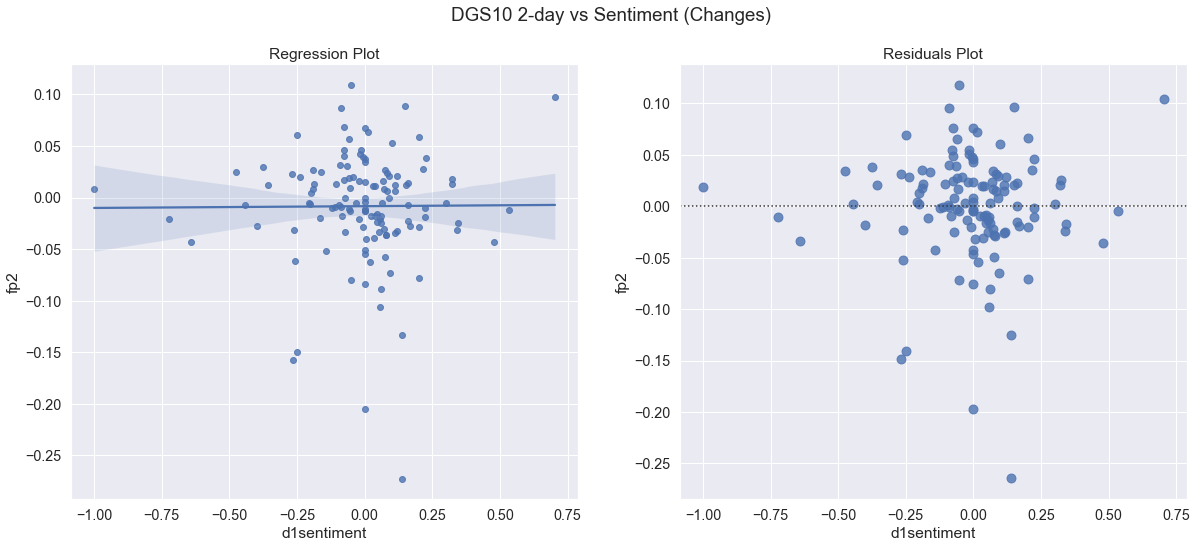

In [151]:
plot_DGS10_fp2()

In [152]:
print(mod_fit_DGS10_fp2.summary())

                            OLS Regression Results                            
Dep. Variable:                    fp2   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                  0.006063
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.938
Time:                        21:35:11   Log-Likelihood:                 189.57
No. Observations:                 125   AIC:                            -375.1
Df Residuals:                     123   BIC:                            -369.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0084      0.005     -1.747      

In [153]:
mod_DGS10_fp2_r2 = mod_fit_DGS10_fp2.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_DGS10_fp2_r2))

The model's R-squared value: 0.000.

In [154]:
mod_DGS10_fp2_var_coef = mod_fit_DGS10_fp2.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_DGS10_fp2_var_coef))

The coefficient of independent variable: 0.002.

In [155]:
mod_DGS10_fp2_pval = mod_fit_DGS10_fp2.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_DGS10_fp2_pval))

The P-value of independent variable: 0.938.

#### Five-Day Difference (fp5)

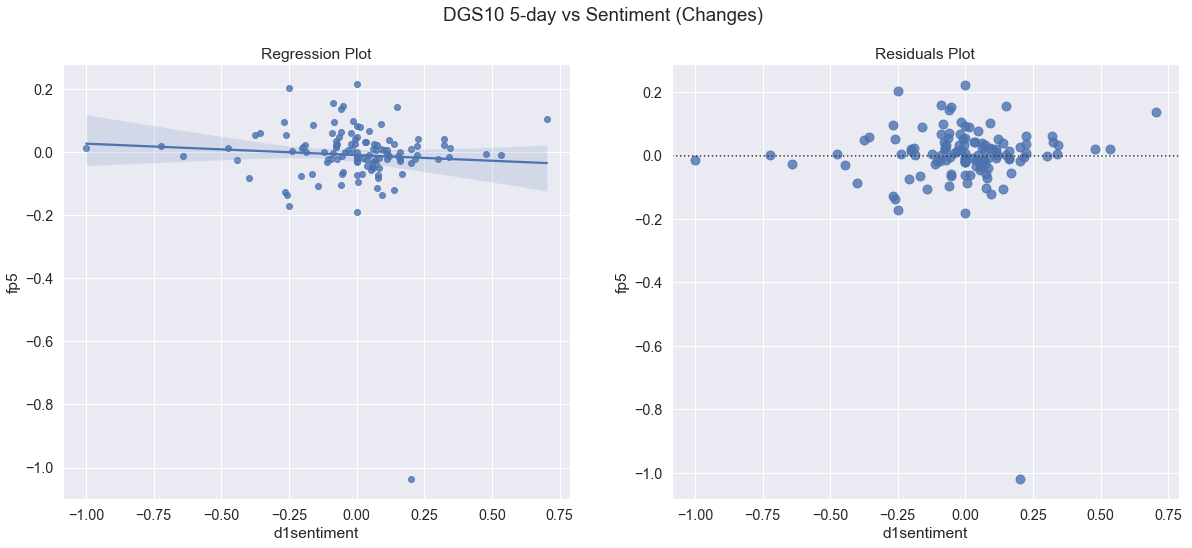

                            OLS Regression Results                            
Dep. Variable:                    fp5   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.5810
Date:                Thu, 19 May 2022   Prob (F-statistic):              0.447
Time:                        21:35:11   Log-Likelihood:                 93.522
No. Observations:                 124   AIC:                            -183.0
Df Residuals:                     122   BIC:                            -177.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0096      0.010     -0.929      

In [156]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))

sns.regplot( x= 'd1sentiment', y = "fp5", data = df_sent_DGS10, fit_reg=True, ax=ax1)
ax1.set_title("Regression Plot")
sns.residplot( x= 'd1sentiment', y = "fp5", data = df_sent_DGS10, scatter_kws={"s": 80})
ax2.set_title("Residuals Plot")
fig.suptitle("DGS10 5-day vs Sentiment (Changes)")
plt.show()

# Generate linear regression model
mod_DGS10_fp5 = sm.OLS(df_sent_DGS10['fp5'], sm.add_constant(df_sent_DGS10['d1sentiment']), missing='drop')
mod_fit_DGS10_fp5 = mod_DGS10_fp5.fit()
print(mod_fit_DGS10_fp5.summary())

In [157]:
mod_DGS10_fp5_r2 = mod_fit_DGS10_fp5.rsquared
md("The model's R-squared value: {:.3f}.".format(mod_DGS10_fp5_r2))

The model's R-squared value: 0.005.

In [158]:
mod_DGS10_fp5_var_coef = mod_fit_DGS10_fp5.params[1]
md("The coefficient of independent variable: {:.3f}.".format(mod_DGS10_fp5_var_coef))

The coefficient of independent variable: -0.036.

In [159]:
mod_DGS10_fp5_pval = mod_fit_DGS10_fp5.pvalues['d1sentiment']
md("The P-value of independent variable: {:.3f}.".format(mod_DGS10_fp5_pval))

The P-value of independent variable: 0.447.

Once again, the sentiment variable, in neither the `fp2` model nor the `fp5` model, explains the variance in the financial variable as both models result in an $R^2$ of 0.005 or less and a coefficient P-value greater than 40%.

### Evaluation

We construct a summary table of the resulting $R^2$, independent variable coefficient, and corresponding P-value. None of the models are statistically significant to consider the macroeconomic variables capable of predicting the FOMC sentiment score, nor to consider the FOMC sentiment score capable of predicting financial market variables across a multiple-day horizon.

In [160]:
list_models = ['CIVPART_bd1', 'UNRATE_bd1', 'PCEPILFE_bp12', 'BAA10Y_fp2', 'BAA10Y_fp5',
               'T10YIE_fp2', 'T10YIE_fp5', 'WILL5000IND_fp2', 'WILL5000IND_fp5', 'DGS10_fp2', 'DGS10_fp5']
list_r2 = [mod_CIVPART_bd1_r2, mod_UNRATE_bd1_r2, mod_PCEPILFE_bp12_r2, mod_BAA10Y_fp2_r2, mod_BAA10Y_fp5_r2,
           mod_T10YIE_fp2_r2, mod_T10YIE_fp5_r2, mod_WILL5000IND_fp2_r2, mod_WILL5000IND_fp5_r2, mod_DGS10_fp2_r2, mod_DGS10_fp5_r2]
list_coef = [mod_CIVPART_bd1_var_coef, mod_UNRATE_bd1_var_coef, mod_PCEPILFE_bp12_var_coef, mod_BAA10Y_fp2_var_coef, mod_BAA10Y_fp5_var_coef,
             mod_T10YIE_fp2_var_coef, mod_T10YIE_fp5_var_coef, mod_WILL5000IND_fp2_var_coef, mod_WILL5000IND_fp5_var_coef, mod_DGS10_fp2_var_coef, mod_DGS10_fp5_var_coef]
list_pval = [mod_CIVPART_bd1_pval, mod_UNRATE_bd1_pval, mod_PCEPILFE_bp12_pval, mod_BAA10Y_fp2_pval, mod_BAA10Y_fp5_pval,
             mod_T10YIE_fp2_pval, mod_T10YIE_fp5_pval, mod_WILL5000IND_fp2_pval, mod_WILL5000IND_fp5_pval, mod_DGS10_fp2_pval, mod_DGS10_fp5_pval]

In [161]:
model_results_df = pd.DataFrame(
    {'Model': list_models,
     'R-squared': list_r2,
     'Variable Coefficient': list_coef,
     'Variable Coefficient P-value': list_pval,
    })

In [162]:

heading_properties = [('font-size', '18px')]

cell_properties = [('font-size', '16px')]

dfstyle = [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]


In [163]:

model_results_df.style.set_table_styles(dfstyle)

,Model,R-squared,Variable Coefficient,Variable Coefficient P-value
0,CIVPART_bd1,0.006066,0.101714,0.387942
1,UNRATE_bd1,0.000547,-0.014406,0.795701
2,PCEPILFE_bp12,0.013943,-19.888330,0.189691
3,BAA10Y_fp2,0.000695,0.002527,0.770454
4,BAA10Y_fp5,0.001123,0.005838,0.711816
5,T10YIE_fp2,0.000660,-0.009314,0.776044
6,T10YIE_fp5,0.000015,-0.001824,0.965658
7,WILL5000IND_fp2,0.009072,-0.008996,0.290706
8,WILL5000IND_fp5,0.010089,-0.012839,0.267008
9,DGS10_fp2,0.000049,0.001715,0.938063


### $\color{green}{\text{ 4.4 - Search for Statistical Significance}}$

#### Wilshire 5000 Stock Index

Given the Wilshire 5000 Stock Index financial variable showed promise with the two-day and five-day difference, we will attempt many different windows of time in hopes of identifying a particular timeframe that shows a statistically significant relationship between the two variables.   However, we need to adjust the statistical significance due to multiple testing otherwise we will overestimate the significance of the $p$-value of the regression.

We will create timeframes going back 5 days prior to the FOMC statement release and looking forward 5 days from the statement release, resulting in a total of 25 timeframes to be considered.



In [164]:
#
#  All the data series to be used in regression analysis.  
# -------------------------------------------------------------------------------------------
series_list = ["WILL5000IND"]

#
# Store the data series in a dictionary with:
#    key:   series key
#    value: DataFrame of dates, raw time series valuees
# 
dict_series = load_and_display_fred_dateseries(series_list, show_plot = False)

#dict_series["WILL5000IND"]

In [165]:
# for loop for Wilshire data
# forward_shift 5 to 0
# period -10 to -5
for fs in range(5,-1,-1):
    for per in range(-fs-5,-fs,1):
        col_name_cat = 'fp'+ str(-1*per) + 's' + str(fs)
        transform_fred_dateseries( dict_series, "WILL5000IND", per,  is_pct = True, col_name = col_name_cat, forward_shift = fs)

In [166]:
WILL5000IND = dict_series["WILL5000IND"]

df_sent_WILL5000IND = pd.merge_asof(df_sentiment, WILL5000IND, left_on = "date", right_on = "DATE")

def find_good_models_will5000ind():
    for fs in range(5,-1,-1):
        #print(fs)
        for per in range(-fs-5,-fs,1):
            y_col = 'fp'+ str(-1*per) + 's' + str(fs)

            # Generate linear regression model
            mod_WILL5000IND = sm.OLS(df_sent_WILL5000IND[y_col], sm.add_constant(df_sent_WILL5000IND['d1sentiment']), missing='drop')
            mod_fit_WILL5000IND = mod_WILL5000IND.fit()
            #print(mod_fit_WILL5000IND.summary())

            pval = mod_fit_WILL5000IND.pvalues['d1sentiment']
            # Only display if p-value less than 10% (0.1)
            if pval < 0.1:
                fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20,8))
                sns.regplot( x= 'd1sentiment', y = y_col, data = df_sent_WILL5000IND, fit_reg=True, ax=ax1)
                ax1.set_title("Regression Plot")
                sns.residplot( x= 'd1sentiment', y = y_col, data = df_sent_WILL5000IND, scatter_kws={"s": 80}, ax=ax2)
                ax2.set_title("Residuals Plot")
                fig.suptitle("WILL5000IND vs Sentiment (Changes): " + y_col)
                plt.show()
                print(mod_fit_WILL5000IND.summary())  

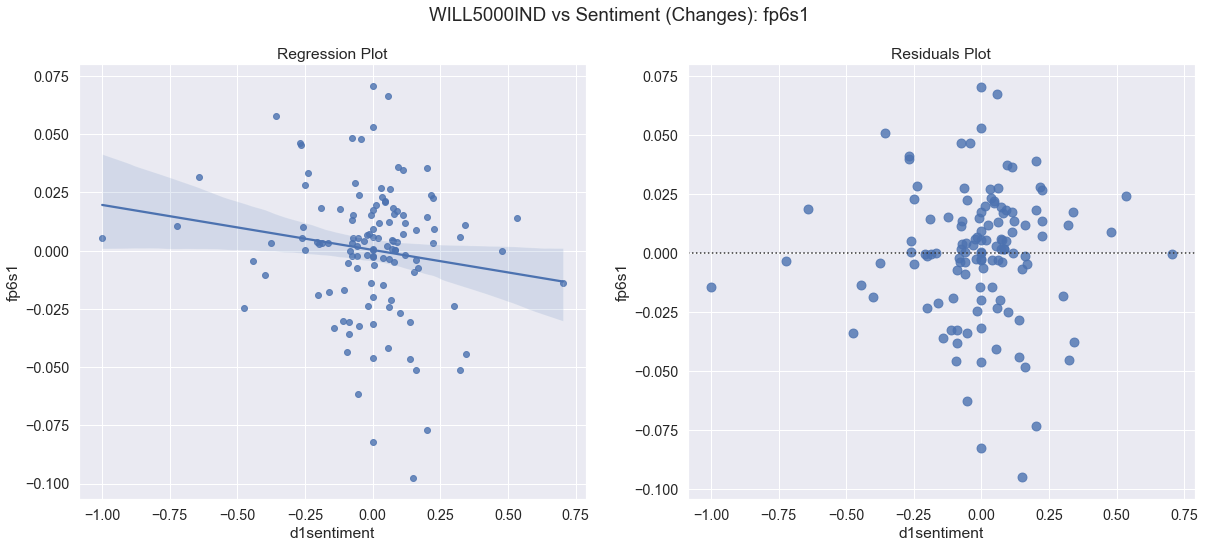

                            OLS Regression Results                            
Dep. Variable:                  fp6s1   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.861
Date:                Thu, 19 May 2022   Prob (F-statistic):             0.0933
Time:                        21:35:12   Log-Likelihood:                 269.88
No. Observations:                 124   AIC:                            -535.8
Df Residuals:                     122   BIC:                            -530.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0003      0.002      0.120      

In [167]:
find_good_models_will5000ind()

Of the 25 timeframes considered, only 1 timeframe - fp6s1, resulted in a coefficient variable P-value below 10%. 
Using a Bonferroni correction of $p/M = 0.10/25 = 0.004$, we rule out the statistical significance of the above `fp6s1` regression result.
The timeframe identified is the difference in the dependent variable from 1 day prior to the FOMC statement to 5 days after the release of the statement, a timeframe spanning 6 days.  
We refer the reader to [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) for more technical details.

### $\color{green}{\text{4.4 - Discussion}}$

The Loughran-McDonald dictionary for financial sentiment in the `PySentiment` library produces a plausible measure of sentiment called polarity.   This measure outperforms the other algorithms implemented in the Python libraries `NLTK`, `TextBlob`, and `Flair`. 

When we regress macroeconomic conditions or financial asset returns on changes in sentiment, the linear regression coefficients are not statistically significant. 
The FOMC statement follows a formulaic approach with boilerplate language and contains tempered language.   Market participants find the subtle changes in the text offer significant guidance on monetary policy and investment consequences.


However, the effects of FOMC statements on financial asset prices are usually measured in minutes not days from the time of their release.

<img src="../raw/Rosa_2013_Panel.jpg"  width="1000" />

Source: [Rossa (2013)]( #Rossa2013 )

In contrast, the effects of macroeconomic indicators on FOMC sentiment appear to have the correct sign even if the statistical significance is weak.

*  A 1-month decline in Labor Force Participation Rate (`CIVPART`) is associated with a subsequent decline in the next FOMC statement sentiment.

*  A 1-month increase in the U3 unemployment rate (`UNRATE`) is associated with a subsequent decline in the next FOMC statement sentiment.

*  A 1-month increase in Personal Consumption Expenditures (`PCEPILFE`) is associated with a subsequent decline in the next FOMC statement sentiment.



## $\color{blue}{\text{5 - Conclusion}}$  <a id="section5"></a>

FOMC members are aware of the Committee's impact on the US economy and global markets through public communications and well as its implemented monetary policy.   FOMC statements express sentiment through their measured used of language.  

*  Through the use of LDA we are able to detect topics that align with periods of quantitative easing.   When we examine the time variation in topic weights, weights appear to follow a 0-1 step function rather showing a fractional value.  
*  We find strong agreement between the start of each QE program to the inception of a new LDA topic.   

*  We speculate that the change may occur because the FOMC is seeking to justify and explain the QE program to its reading audience in new language.  

*  The end of a QE program can be harder to detect possibly because the central bank has less urgency to signal the end to the market than the beginning.

FOMC statements also express sentiment that can be measured using the Loughran-McDonald financial dictionary.

* We find the `Pysentiment` polarity measure works well.  It produces sentiment changes consistent with the 2008 and 2020 recession.

* Other sentiment algorithms such as `Flair`, `TextBlob` and `NLTK` Vader are inconsistent with the recent recessions.

* Multi-day regression of financial asset returns versus sentiment changes between FOMC meetings are not statistical significant.  This is consistent with but contrary to the statistical patterns of intraday price returns versus FOMC announcement releases.   We speculate that much of the FOMC price impact  is realized within the first 1-2 hours for stocks, Treasuries and credit spreads and undetectable at 2-5 day horizons.

Topic Modeling and sentiment analysis of FOMC statements may not delivery unexpected insights on monetary policy or asset returns.  However, they quantify the important aspects of these texts that are usually evaluated subjectively by a human analyst.   That may be a valuable  complement to the reading audience of FOMC statements.

## $\color{blue}{\text{6 - References}}$  <a id="section6"></a>

<a id="Rossa2013">Carlo Rossa, 2013.</a>  **"The Financial Market Effect of FOMC Minutes"**  Economic Policy Review, Vol. 19, No. 2, 2013  (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2378398)

<a id='GuKurovWolf2018'>Gu, Chen & Kurov, Alexander & Wolfe, Marketa Halova, 2018.</a> **"Relief Rallies after FOMC Announcements as a Resolution of Uncertainty,"** Journal of Empirical Finance, Elsevier, vol. 49(C), pages 1-18.

<a id='LuccaTrebbi2009'>David O. Lucca & Francesco Trebbi, 2009.</a> **"Measuring Central Bank Communication: An Automated Approach with Application to FOMC Statements,"** NBER Working Papers 15367, National Bureau of Economic Research, Inc. (https://www.nber.org/papers/w15367)

<a id='CieslakMorseVissingJorgensen2019'> A Cieslak, A Morse, A Vissing-Jorgensen, 2019.</a> **"Stock returns over the FOMC cycle"**, Journal of Finance 74(5), 2201-2248 (https://drive.google.com/file/d/1wpT8A2IpMYBP1ytt8n9mk9AdBsnfQ0Ps/view) 

<a id='Cannon2015'>Cannon, S. (2015).</a> **Sentiment of the FOMC: Unscripted.** Economic Review-Federal Reserve Bank of Kansas City, 5. (https://www.kansascityfed.org/documents/545/2015-Sentiment%20of%20the%20FOMC:%20Unscripted.pdf)

<a id='Gutierrez2020'>Gutierrez, L. F., Siami-Namini, S., Tavakoli, N., & Namin, A. S. (2020, December).</a> **A Concern Analysis of Federal Reserve Statements: The Great Recession vs. The COVID-19 Pandemic.** In 2020 IEEE International Conference on Big Data (Big Data) (pp. 2079-2086). IEEE. (https://arxiv.org/pdf/2012.02098.pdf

<a id="Lagana2020">Laganà, D. M. (2020).</a> **Federal reserve’s communication: a latent dirichlet allocation analysis with application to FOMC minutes.**  (http://tesi.luiss.it/27972/1/713391_LAGANA%27_DAISY%20MARTINA.pdf)


<a id="JegadeeshWu2017">Jegadeesh, N., & Wu, D. (2017).</a> **Deciphering Fedspeak: The information content of FOMC meetings.** SSRN (https://www.aeaweb.org/conference/2016/retrieve.php?pdfid=21466&tk=niAkBk3N)


## $\color{blue}{\text{7 - Appendices}}$ <a id="section7"></a>

## Technical Appendix

The data table for the QE program topics in the LDA model is shown below.

In [168]:
with pd.option_context('display.max_rows' , 200 ):
    print(topic_weights_hist )

                 QE3       QE1       QE4       QE2   QE-HALT
date                                                        
2007-01-31  0.000000  0.000000  0.000000  0.970152  0.000000
2007-03-21  0.000000  0.000000  0.000000  0.969345  0.000000
2007-05-09  0.000000  0.000000  0.000000  0.970305  0.000000
2007-06-28  0.000000  0.000000  0.000000  0.971399  0.000000
2007-08-07  0.000000  0.000000  0.000000  0.973179  0.000000
2007-09-18  0.000000  0.975816  0.000000  0.000000  0.000000
2007-10-31  0.000000  0.978990  0.000000  0.000000  0.000000
2007-12-11  0.000000  0.976799  0.000000  0.000000  0.000000
2008-01-22  0.000000  0.974007  0.000000  0.000000  0.000000
2008-01-30  0.000000  0.976185  0.000000  0.000000  0.000000
2008-03-18  0.000000  0.979066  0.000000  0.000000  0.000000
2008-04-30  0.000000  0.979544  0.000000  0.000000  0.000000
2008-06-25  0.000000  0.977396  0.000000  0.000000  0.000000
2008-08-05  0.000000  0.976586  0.000000  0.000000  0.000000
2008-09-16  0.000000  0.